### To-Do
Avg. CV IKI by word type (WF and BF)  
Words with highest/lowest CV IKI  
Bigrams with highest/lowest CV IKI  
Difference between avg. CV IKI by word type between individuals  

In [183]:
import numpy as np
import pandas as pd
import ast
import math
import glob
import matplotlib.pyplot as plt
from scipy.stats import variation
from scipy.stats import ranksums
import warnings
from statsmodels.stats.anova import AnovaRM
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

import typingmod as typ

## Dataframe Setup

In [2]:
np.seterr(invalid='ignore') ## gets rid of runtime error about invalid division

ID_list = ['s83', 's20', 's175', 's178', 's179', 's180', 's181', 's182', 's183', 's189', 's190']

##, 'p09', 'p10', 'p11'

In [3]:
## making one trial based dataframe using data from all participants
all_maindfs = glob.glob("subject_data/main_dfs/*.csv")
all_trials = (pd.concat((pd.read_csv(f) for f in all_maindfs))).reset_index(drop=True)
# print(all_trials)

## making dataframe of only rts from all trials
all_rts = typ.rt_columns(all_trials)

## adding ikis to main dataframe using all_rts
all_trials = pd.concat([all_trials, typ.iki(all_rts).iloc[:,1:7]], axis = 1)
all_trials = all_trials.rename(columns={0: 'iki_1', 1: 'iki_2', 2: 'iki_3', 3: 'iki_4', 4: 'iki_5', 5: 'iki_6'})
all_trials = all_trials.drop(columns=['Unnamed: 0'])

## making one trial based dataframe using data from all participants
all_bigramdfs = glob.glob("subject_data/bigram_dfs/*.csv")
all_bigrams = (pd.concat((pd.read_csv(f) for f in all_bigramdfs))).reset_index(drop=True)
all_bigrams['Bigram'] = all_bigrams['Bigram'].apply(lambda x: (x.replace("'", "")).replace(" ", ""))
all_bigrams = all_bigrams.rename(columns = {'Trial #': 'trial', 'bigram #': 'bigram_num', 'Bigram': 'bigram'})
all_bigrams = all_bigrams.drop(columns=['Unnamed: 0'])

## making filtered dataframes
corr_trials = (all_trials[all_trials.string == all_trials.resp_string]).reset_index(drop=True)
incorr_trials = (all_trials[all_trials.string != all_trials.resp_string]).reset_index(drop=True)

corr_trials_bybg = typ.correct_filter(all_bigrams) ## only correct trials
incorr_trials_bybg = typ.incorrect_filter(all_bigrams) ## only incorrect trials

corr_bgs = (all_bigrams[all_bigrams.bigram == all_bigrams.corr_bigram]).reset_index(drop=True)
incorr_bgs = (all_bigrams[all_bigrams.bigram != all_bigrams.corr_bigram]).reset_index(drop=True)

corr_rts = typ.rt_columns(corr_trials) ## only correct rts
incorr_rts = typ.rt_columns(incorr_trials) ## only incorrect rts

## making filtered dataframes by word frequency
highwf_df = all_trials[all_trials['string'].isin(typ.highwf)]
medwf_df = all_trials[all_trials['string'].isin(typ.medwf)]
lowwf_df = all_trials[all_trials['string'].isin(typ.lowwf)]
pseudo_df = all_trials[all_trials['string'].isin(typ.pseudo)]

## making filtered dataframes by bigram frequency
highbf_df = all_trials[all_trials['string'].isin(typ.highbf)]
medbf_df = all_trials[all_trials['string'].isin(typ.medbf)]
lowbf_df = all_trials[all_trials['string'].isin(typ.lowbf)]

## making dataframes with rts by word frequency type
highwf_rts = (typ.rt_columns(highwf_df)).reset_index(drop=True)
medwf_rts = (typ.rt_columns(medwf_df)).reset_index(drop=True)
lowwf_rts = (typ.rt_columns(lowwf_df)).reset_index(drop=True)
pseudo_rts = (typ.rt_columns(pseudo_df)).reset_index(drop=True)

## making dataframes with rts by bigram frequency type
highbf_rts = (typ.rt_columns(highbf_df)).reset_index(drop=True)
medbf_rts = (typ.rt_columns(medbf_df)).reset_index(drop=True)
lowbf_rts = (typ.rt_columns(lowbf_df)).reset_index(drop=True)

## making dataframe with only correct trials that have ikis within 2sd of the inividuals mean iki (iki is by posiiton)
tight_trials = pd.DataFrame()
for subject in ID_list:
    sub_df = corr_trials[corr_trials.sID == subject]
    for col in sub_df.iloc[:, 24:28]: ## depends on position of iki columns
        avg_iki = sub_df[col].mean()
        sd_iki = sub_df[col].std()
        sub_df = sub_df.loc[(sub_df[col] < (avg_iki + 2*sd_iki)) & (sub_df[col] > (avg_iki - 2*sd_iki))]
    tight_trials = pd.concat([tight_trials, sub_df])
    
## making dataframe with only correct bigrams that have ikis within 2sd of the individuals mean iki (across all ikis)
tight_bgs = pd.DataFrame()
for subject in ID_list:
    sub_df = corr_trials_bybg[corr_trials_bybg.sID == subject]
    avg_iki = sub_df['IKI'].mean()
    sd_iki = sub_df['IKI'].std()
    sub_df = sub_df[(sub_df.IKI < (avg_iki + 2*sd_iki)) & (sub_df.IKI > (avg_iki - 2*sd_iki))]
    tight_bgs = pd.concat([tight_bgs, sub_df])
    
## making dataframe with both correct and incorrect bigrams that have ikis within 2sd
all_tight_bgs = pd.DataFrame()
for subject in ID_list:
    sub_df = all_bigrams[all_bigrams.sID == subject]
    avg_iki = sub_df['IKI'].mean()
    sd_iki = sub_df['IKI'].std()
    sub_df = sub_df[(sub_df.IKI < (avg_iki + 2*sd_iki)) & (sub_df.IKI > (avg_iki - 2*sd_iki))]
    all_tight_bgs = pd.concat([all_tight_bgs, sub_df])

In [4]:
all_bigrams

sID  Bigram #  trial  bigram_loc bigram corr_bigram       IKI string  \
0      s175         0      0           0     co          co  0.240044  cooed   
1      s175         1      0           1     oo          oo  0.135961  cooed   
2      s175         2      0           2     oe          oe  0.111992  cooed   
3      s175         3      0           3     ed          ed  0.184002  cooed   
4      s175         4      1           0     th          th  0.119998  there   
...     ...       ...    ...         ...    ...         ...       ...    ...   
10612  s189       957    238           3     dy          dy  0.136057  buddy   
10613  s189       958    239           0     th          th  0.096004  think   
10614  s189       959    239           1     hi          hi  0.168020  think   
10615  s189       960    239           2     in          in  0.168060  think   
10616  s189       961    239           3     nk          nk  0.151912  think   

      resp_string  rep #  
0           cooed      0  
1           cooed      0  
2           cooed      0  
3           cooed      0  
4           there      0  
...           ...    ...  
10612       buddy      9  
10613       think      9  
10614       think      9  
10615       think      9  
10616       think      9  

[10617 rows x 10 columns]

## Variables by Word and Word Type (WF and BF)

In [5]:
plt.rcParams['font.size'] = '30'

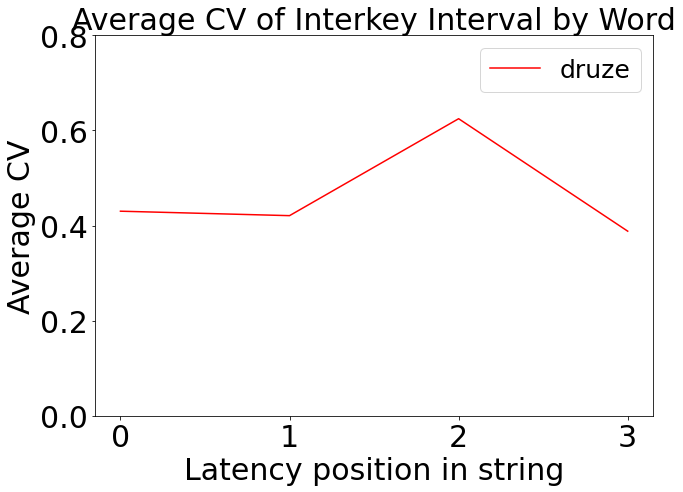

In [6]:
## creating dataframe from 'cv_byword' function that is easy to plot
cv_word = 'druze' # change this for which ever word you want to plot
cv_byword_df = (pd.DataFrame(typ.cv_byword(cv_word, corr_rts)).drop(0)).reset_index(drop = True)

## plotting digraph latency variations by word (does not include error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
highwf_plot = plt.plot(cv_byword_df, color='red', label=cv_word)
# medwf_plot = plt.plot(cv_byword_df, color='red', label='There')

## Set general font size
plt.rcParams['font.size'] = '25'

plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Latency position in string")
plt.ylabel("Average CV")
plt.ylim([0, 0.8])
plt.title("Average CV of Interkey Interval by Word")
plt.legend(loc="best")

plt.show()

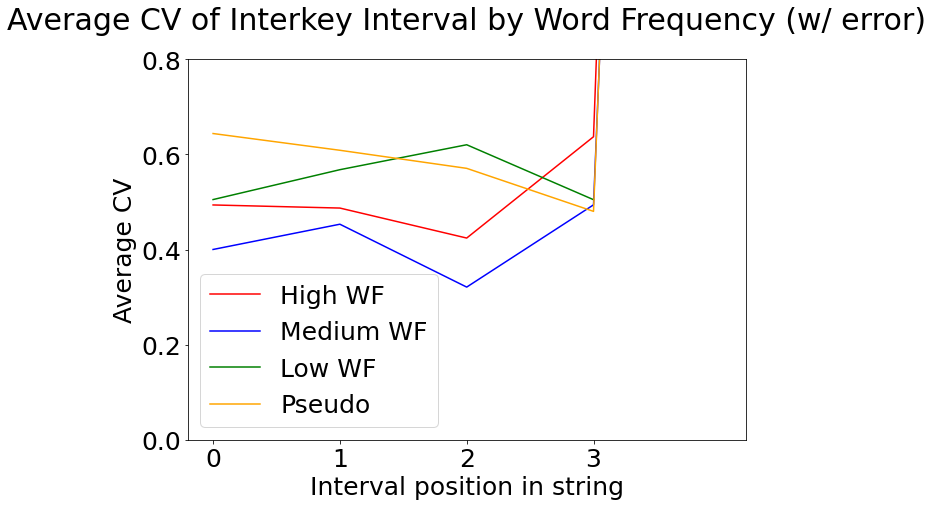

In [7]:
## plotting digraph latency variations by WF type (includes error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
highwf_plot = plt.plot(typ.avg_cv(typ.highwf, all_rts), color='red', label='High WF')
medwf_plot = plt.plot(typ.avg_cv(typ.medwf, all_rts), color='blue', label='Medium WF')
lowwf_plot = plt.plot(typ.avg_cv(typ.lowwf, all_rts), color='green', label='Low WF')
pseudo_plot = plt.plot(typ.avg_cv(typ.pseudo, all_rts), color='orange', label='Pseudo')

## Set tick font size
# for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#     label.set_fontsize(25)

plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Interval position in string")
plt.ylabel("Average CV")
plt.ylim([0, 0.8])
plt.title("Average CV of Interkey Interval by Word Frequency (w/ error)", pad=30)
plt.legend(loc="best")

# plt.savefig('ian_iki.png')

plt.show()

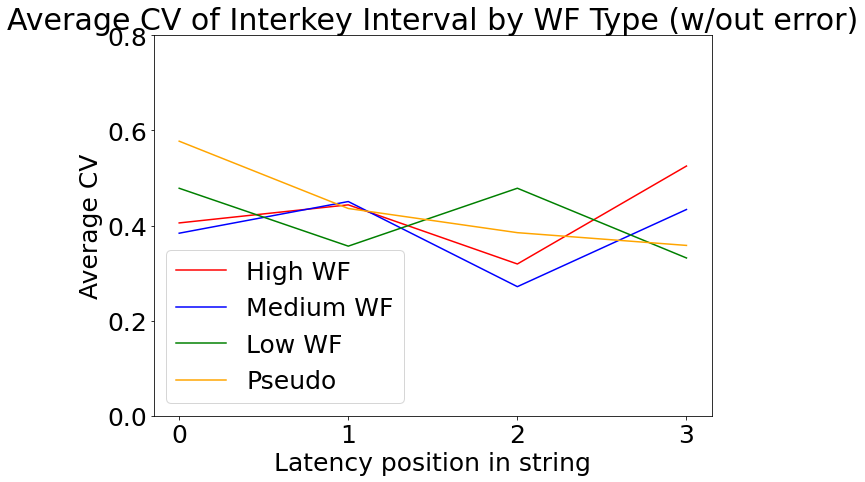

In [8]:
## plotting digraph latency variations by WF type (does not include error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
highwf_plot = plt.plot(typ.avg_cv(typ.highwf, corr_rts), color='red', label='High WF')
medwf_plot = plt.plot(typ.avg_cv(typ.medwf, corr_rts), color='blue', label='Medium WF')
lowwf_plot = plt.plot(typ.avg_cv(typ.lowwf, corr_rts), color='green', label='Low WF')
pseudo_plot = plt.plot(typ.avg_cv(typ.pseudo, corr_rts), color='orange', label='Pseudo')


plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Latency position in string")
plt.ylabel("Average CV")
plt.ylim([0, 0.8])
plt.title("Average CV of Interkey Interval by WF Type (w/out error)")
plt.legend(loc="best")

plt.show()

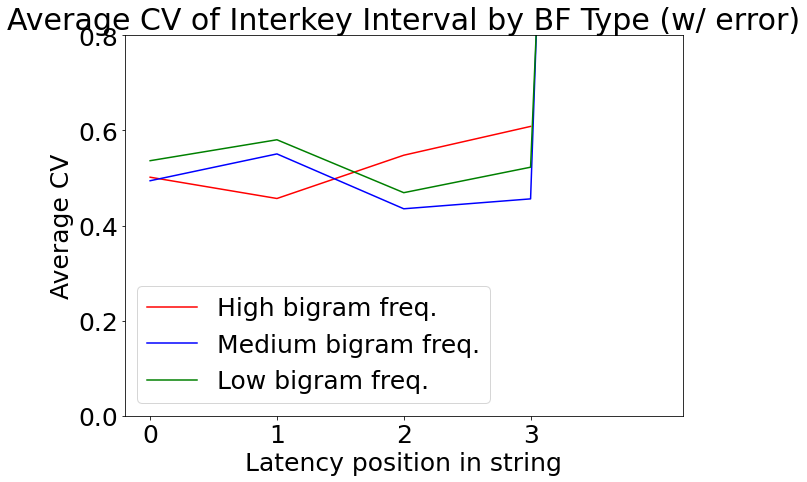

In [9]:
## plotting digraph latency variations by BF type (includes error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
highbf_plot = plt.plot(typ.avg_cv(typ.highbf, all_rts), color='red', label='High bigram freq.')
medbf_plot = plt.plot(typ.avg_cv(typ.medbf, all_rts), color='blue', label='Medium bigram freq.')
lowbf_plot = plt.plot(typ.avg_cv(typ.lowbf, all_rts), color='green', label='Low bigram freq.')

plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Latency position in string")
plt.ylabel("Average CV")
plt.ylim([0, 0.8])
plt.title("Average CV of Interkey Interval by BF Type (w/ error)")
plt.legend(loc="best")

plt.show()

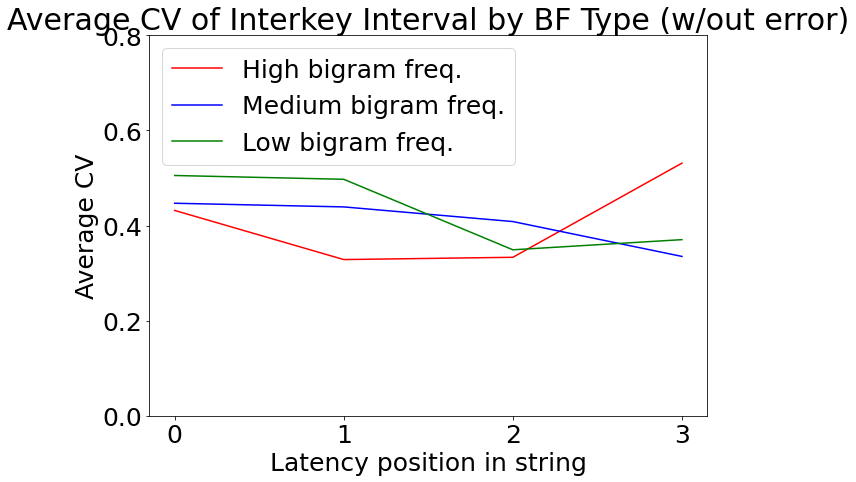

In [10]:
## plotting digraph latency variations by BF type (does not include error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
highbf_plot = plt.plot(typ.avg_cv(typ.highbf, corr_rts), color='red', label='High bigram freq.')
medbf_plot = plt.plot(typ.avg_cv(typ.medbf, corr_rts), color='blue', label='Medium bigram freq.')
lowbf_plot = plt.plot(typ.avg_cv(typ.lowbf, corr_rts), color='green', label='Low bigram freq.')


plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Latency position in string")
plt.ylabel("Average CV")
plt.ylim([0, 0.8])
plt.title("Average CV of Interkey Interval by BF Type (w/out error)")
plt.legend(loc="best")

plt.show()

In [11]:
# figure, axs = plt.subplots(2, 2, figsize=(20, 14))
# figure.suptitle('IKI Distribution by WF', y=0.95)

# axs[0, 0].boxplot((typ.iki(highwf_rts)).loc[:, 0:3])
# axs[0, 0].set_title("High WF")
# # axs[0, 0].set_median(linewidth = 3)
# # axs[0, 0].set_ylim([-0.01, 1])
# axs[0, 1].boxplot((typ.iki(medwf_rts)).loc[:, 0:3])
# axs[0, 1].set_title("Med WF")
# # axs[0, 1].set_ylim([-0.01, 1])
# axs[1, 0].boxplot((typ.iki(lowwf_rts)).loc[:, 0:3])
# axs[1, 0].set_title("Low WF")
# # axs[1, 0].set_ylim([-0.01, 1])
# axs[1, 1].boxplot((typ.iki(pseudo_rts)).loc[:, 0:3])
# axs[1, 1].set_title("Pseudo")
# # axs[1, 1].set_ylim([-0.01, 1])

# for ax in axs.flat:
#     ax.set(ylabel='IKI (s)', xlabel='IKI Postion in String')

# ## Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [12]:
highwf_ikis = pd.concat([typ.iki(highwf_rts)[0], typ.iki(highwf_rts)[1], typ.iki(highwf_rts)[2], typ.iki(highwf_rts)[3]], axis=0, ignore_index=True)
medwf_ikis = pd.concat([typ.iki(medwf_rts)[0], typ.iki(medwf_rts)[1], typ.iki(medwf_rts)[2], typ.iki(medwf_rts)[3]], axis=0, ignore_index=True)
lowwf_ikis = pd.concat([typ.iki(lowwf_rts)[0], typ.iki(lowwf_rts)[1], typ.iki(lowwf_rts)[2], typ.iki(lowwf_rts)[3]], axis=0, ignore_index=True)
pseudo_ikis = pd.concat([typ.iki(pseudo_rts)[0], typ.iki(pseudo_rts)[1], typ.iki(pseudo_rts)[2], typ.iki(pseudo_rts)[3]], axis=0, ignore_index=True)

highbf_ikis = pd.concat([typ.iki(highbf_rts)[0], typ.iki(highbf_rts)[1], typ.iki(highbf_rts)[2], typ.iki(highbf_rts)[3]], axis=0, ignore_index=True)
medbf_ikis = pd.concat([typ.iki(medbf_rts)[0], typ.iki(medbf_rts)[1], typ.iki(medbf_rts)[2], typ.iki(medbf_rts)[3]], axis=0, ignore_index=True)
lowbf_ikis = pd.concat([typ.iki(lowbf_rts)[0], typ.iki(lowbf_rts)[1], typ.iki(lowbf_rts)[2], typ.iki(lowbf_rts)[3]], axis=0, ignore_index=True)

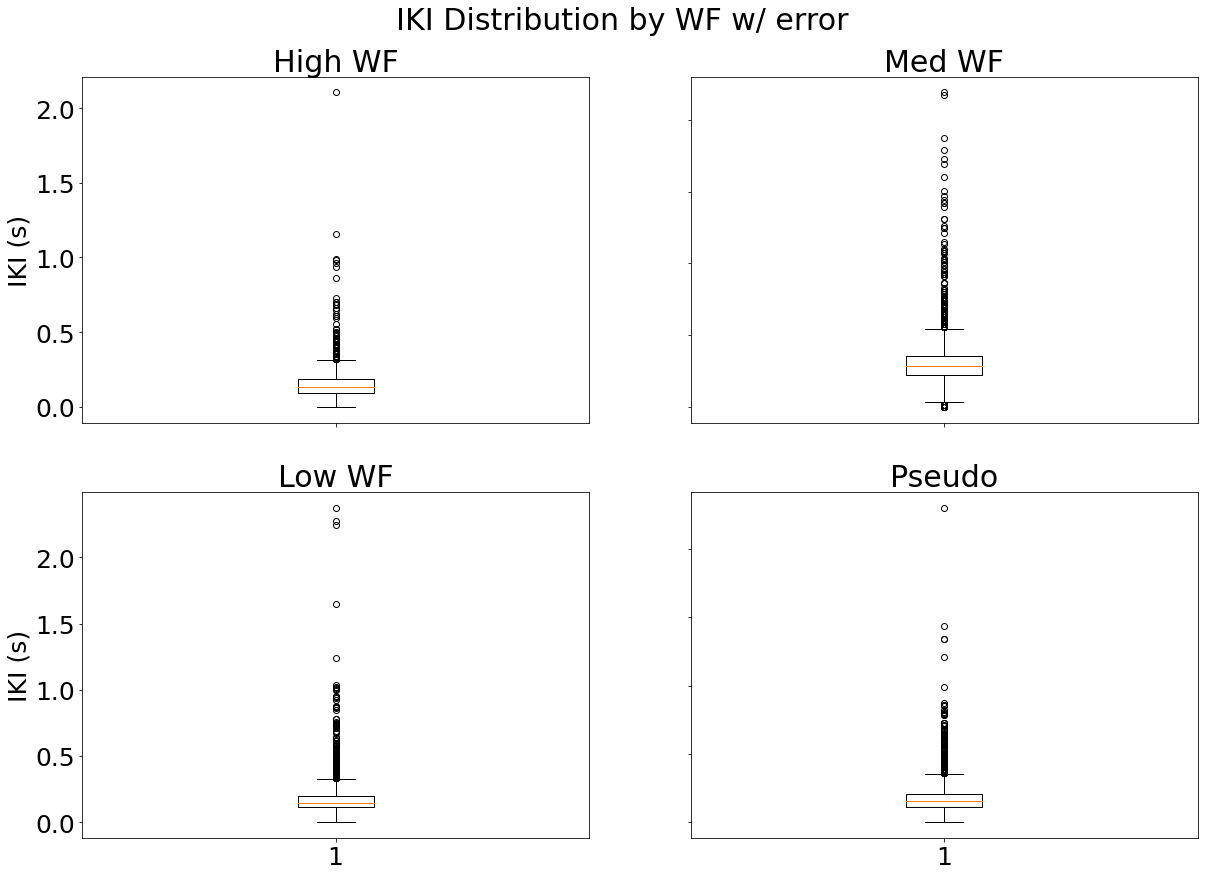

In [13]:
figure, axs = plt.subplots(2, 2, figsize=(20, 14))
figure.suptitle('IKI Distribution by WF w/ error', y=0.95)

axs[0, 0].boxplot(highwf_ikis)
axs[0, 0].set_title("High WF")
# axs[0, 0].set_median(linewidth = 3)
# axs[0, 0].set_ylim([-0.01, 1])
axs[0, 1].boxplot(medwf_ikis)
axs[0, 1].set_title("Med WF")
# axs[0, 1].set_ylim([-0.01, 1])
axs[1, 0].boxplot(lowwf_ikis)
axs[1, 0].set_title("Low WF")
# axs[1, 0].set_ylim([-0.01, 1])
axs[1, 1].boxplot(pseudo_ikis)
axs[1, 1].set_title("Pseudo")
# axs[1, 1].set_ylim([-0.01, 1])

for ax in axs.flat:
    ax.set(ylabel='IKI (s)', xlabel='')

## Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

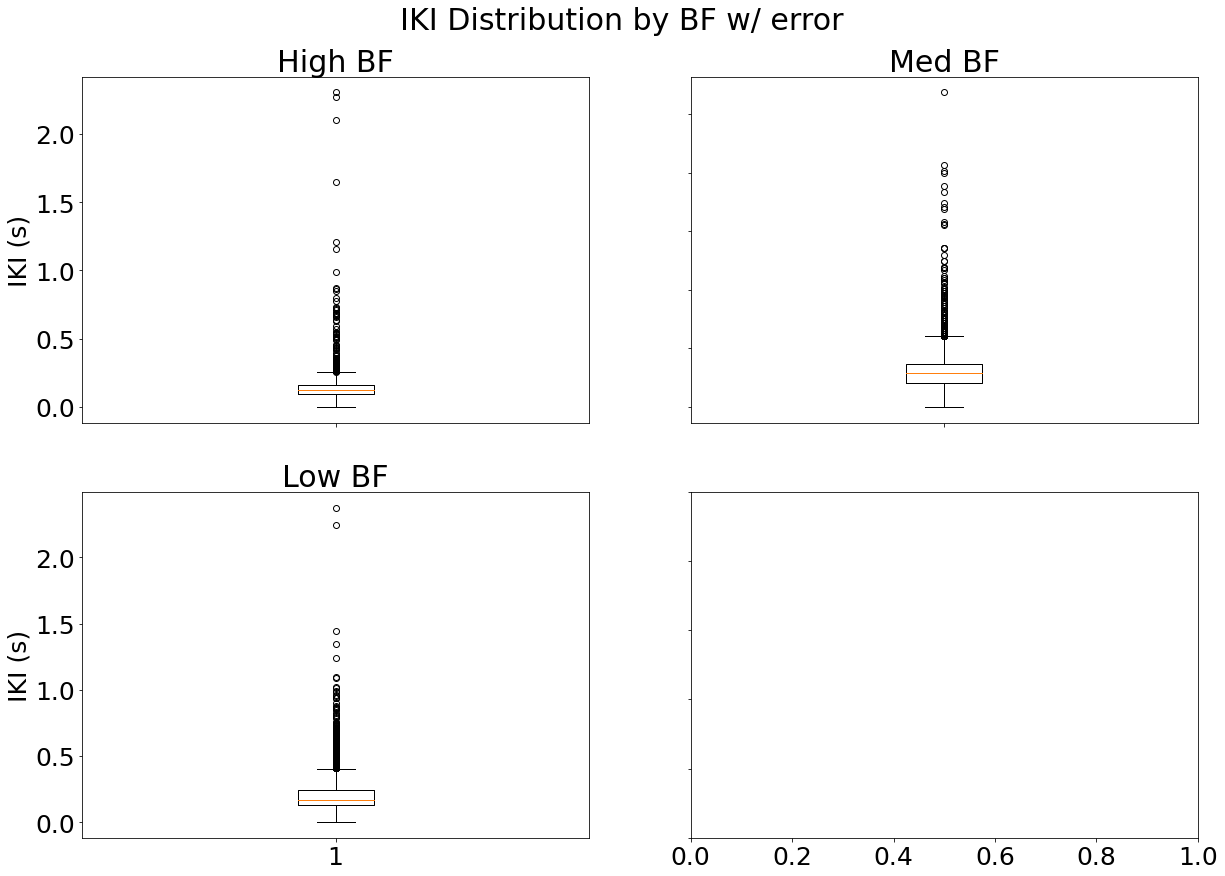

In [14]:
figure, axs = plt.subplots(2, 2, figsize=(20, 14))
figure.suptitle('IKI Distribution by BF w/ error', y=0.95)

axs[0, 0].boxplot(highbf_ikis)
axs[0, 0].set_title("High BF")
# axs[0, 0].set_median(linewidth = 3)
# axs[0, 0].set_ylim([-0.01, 1])
axs[0, 1].boxplot(medbf_ikis)
axs[0, 1].set_title("Med BF")
# axs[0, 1].set_ylim([-0.01, 1])
axs[1, 0].boxplot(lowbf_ikis)
axs[1, 0].set_title("Low BF")
# axs[1, 0].set_ylim([-0.01, 1])

for ax in axs.flat:
    ax.set(ylabel='IKI (s)', xlabel='')

## Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

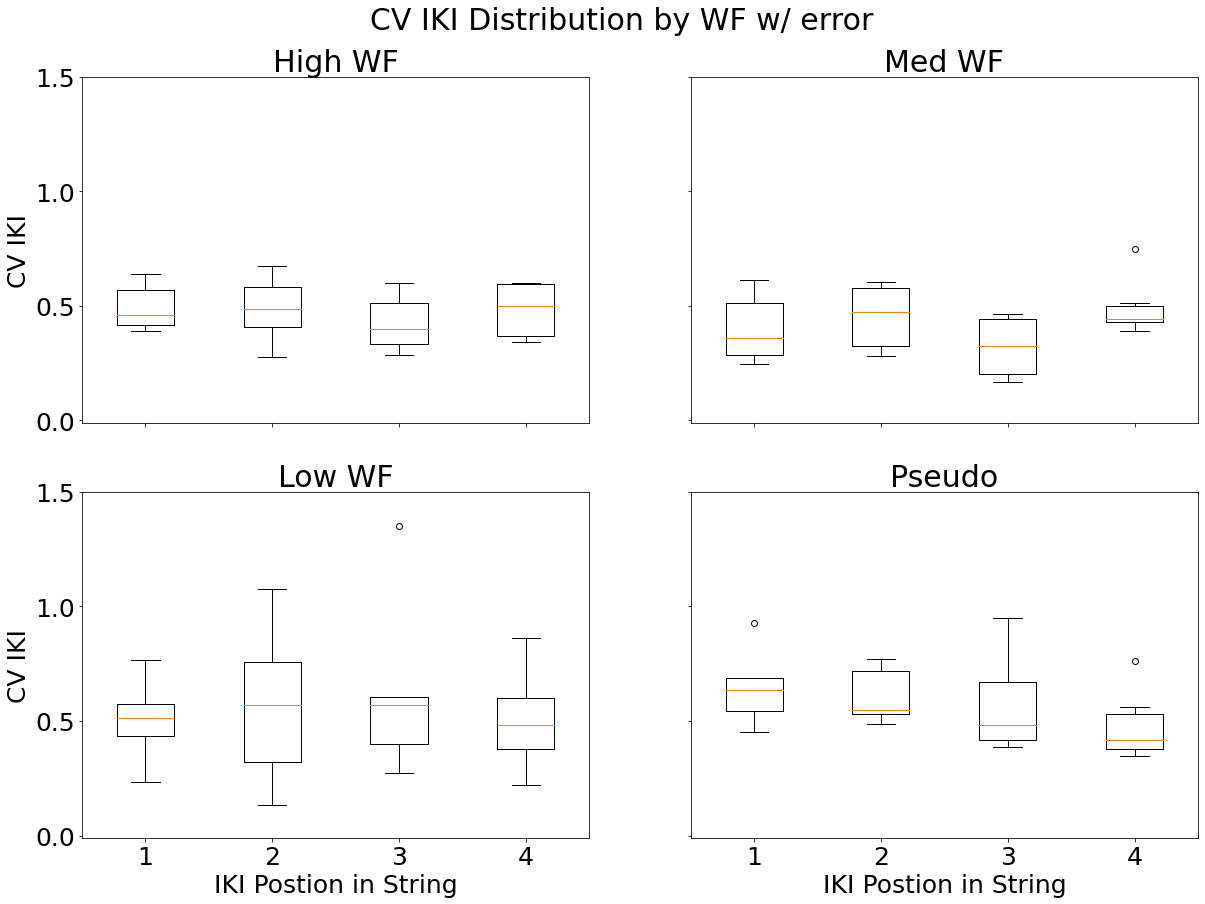

In [15]:
figure, axs = plt.subplots(2, 2, figsize=(20, 14))
figure.suptitle('CV IKI Distribution by WF w/ error', y=0.95)

axs[0, 0].boxplot((typ.cv_all(typ.highwf, all_rts).loc[:, 1:4]))
axs[0, 0].set_title("High WF")
axs[0, 0].set_ylim([-0.01, 1.5])
axs[0, 1].boxplot((typ.cv_all(typ.medwf, all_rts).loc[:, 1:4]))
axs[0, 1].set_title("Med WF")
axs[0, 1].set_ylim([-0.01, 1.5])
axs[1, 0].boxplot((typ.cv_all(typ.lowwf, all_rts).loc[:, 1:4]))
axs[1, 0].set_title("Low WF")
axs[1, 0].set_ylim([-0.01, 1.5])
axs[1, 1].boxplot((typ.cv_all(typ.pseudo, all_rts).loc[:, 1:4]))
axs[1, 1].set_title("Pseudo")
axs[1, 1].set_ylim([-0.01, 1.5])

for ax in axs.flat:
    ax.set(ylabel='CV IKI', xlabel='IKI Postion in String')

## Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

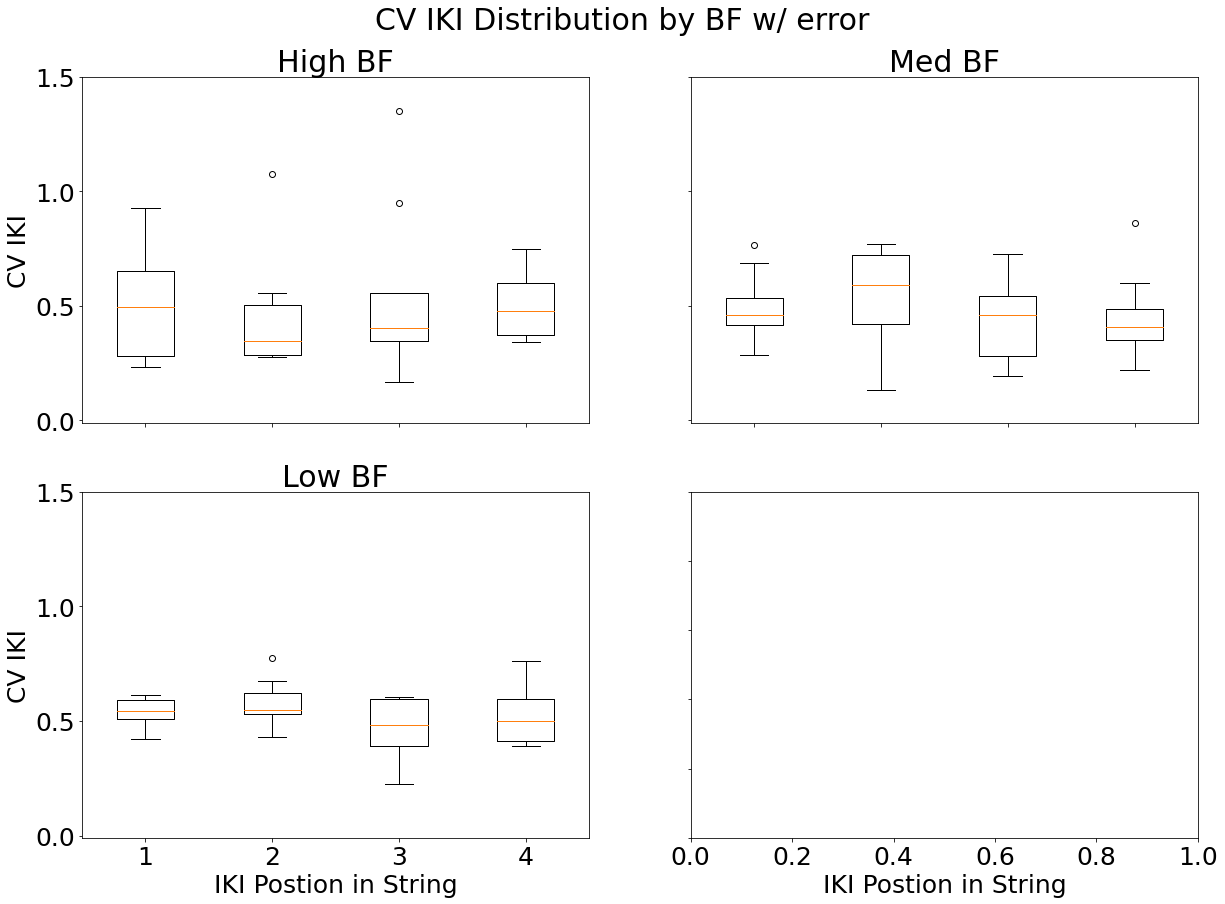

In [16]:
figure, axs = plt.subplots(2, 2, figsize=(20, 14))
figure.suptitle('CV IKI Distribution by BF w/ error', y=0.95)

axs[0, 0].boxplot((typ.cv_all(typ.highbf, all_rts).loc[:, 1:4]))
axs[0, 0].set_title("High BF")
axs[0, 0].set_ylim([-0.01, 1.5])
axs[0, 1].boxplot((typ.cv_all(typ.medbf, all_rts).loc[:, 1:4]))
axs[0, 1].set_title("Med BF")
axs[0, 1].set_ylim([-0.01, 1.5])
axs[1, 0].boxplot((typ.cv_all(typ.lowbf, all_rts).loc[:, 1:4]))
axs[1, 0].set_title("Low BF")
axs[1, 0].set_ylim([-0.01, 1.5])

for ax in axs.flat:
    ax.set(ylabel='CV IKI', xlabel='IKI Postion in String')

## Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [17]:
## defining function for finding CV IKI avg for each individual
def avgcv_bysub(word_type, DF):
    sub_avgs =[]
    for sub in ID_list:
        sub_data = pd.DataFrame()
        for index, data in DF.iterrows():
            if DF.loc[index, 'sID'] == sub:
                sub_data = sub_data.append(DF.loc[index], ignore_index=True)
        sub_avg = typ.avg_cv(word_type, sub_data)
        sub_avg.insert(0, sub)
        sub_avgs.append(sub_avg)
    sub_avgs = pd.DataFrame(sub_avgs, columns = ['sID', 'Avg CV 1', 'Avg CV 2', 'Avg CV 3', 'Avg CV 4'])
    return sub_avgs

## defining function for finding Avg IKI for each individual
def avgposiki_bysub(DF):
    sub_avgs =[]
    for sub in ID_list:
        sub_data = pd.DataFrame()
        for index, data in DF.iterrows():
            if DF.loc[index, 'sID'] == sub:
                sub_data = sub_data.append(DF.loc[index], ignore_index=True)
        ikis = typ.iki(sub_data)
        sub_avg = []
        ikis.iloc[:, 1:5].mean()
        sub_avg.insert(0, sub)
        sub_avgs.append(sub_avg)
    sub_avgs = pd.DataFrame(sub_avgs, columns = ['sID', 'Avg IKI 1', 'Avg IKI 2', 'Avg IKI 3', 'Avg IKI 4'])
    return sub_avgs

def avgiki_bysub(DF):
    sub_avgs =[]
    for sub in ID_list:
        sub_data = pd.DataFrame()
        for index, data in DF.iterrows():
            if DF.loc[index, 'sID'] == sub:
                sub_data = sub_data.append(DF.loc[index], ignore_index=True)
        ikis = typ.iki(sub_data)
        iki_list = pd.concat([ikis[1], ikis[2], ikis[3], ikis[4]], ignore_index=True)
        sub_avg = []
        sub_avg.append(np.mean(iki_list))
        sub_avg.insert(0, sub)
        sub_avgs.append(sub_avg)
    sub_avgs = pd.DataFrame(sub_avgs, columns = ['sID', 'Avg IKI'])
    return sub_avgs

# def avgiki_bysub_bg(DF):
#     sub_avgs =[]
#     for sub in ID_list:
#         sub_data = pd.DataFrame()
#         for index, data in DF.iterrows():
#             if DF.loc[index, 'sID'] == sub:
#                 sub_data = sub_data.append(DF.loc[index], ignore_index=True)
#         sub_avg = []
#         sub_avg.append(np.mean(sub_data['IKI']))
#         sub_avg.insert(0, sub)
#         sub_avgs.append(sub_avg)
#     sub_avgs = pd.DataFrame(sub_avgs, columns = ['sID', 'Avg IKI'])
#     return sub_avgs

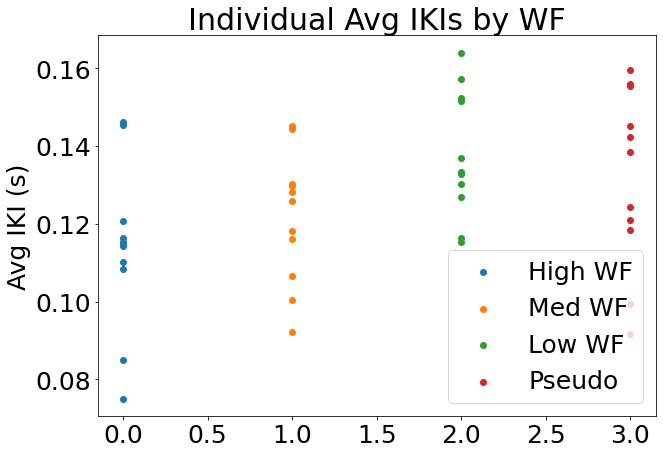

In [18]:
plt.figure(figsize=(10, 7))
highwf_scatter = plt.scatter(([0] * len((avgiki_bysub(highwf_rts)).iloc[:, 1])), avgiki_bysub(highwf_rts).iloc[:, 1], label='High WF')
medwf_scatter = plt.scatter(([1] * len((avgiki_bysub(medwf_rts)).iloc[:, 1])), avgiki_bysub(medwf_rts).iloc[:, 1], label='Med WF')
lowwf_scatter = plt.scatter(([2] * len((avgiki_bysub(lowwf_rts)).iloc[:, 1])), avgiki_bysub(lowwf_rts).iloc[:, 1], label='Low WF')
pseudo_scatter = plt.scatter(([3] * len((avgiki_bysub(pseudo_rts)).iloc[:, 1])), avgiki_bysub(pseudo_rts).iloc[:, 1], label='Pseudo')

plt.xlabel("")
plt.ylabel("Avg IKI (s)")
plt.title("Individual Avg IKIs by WF")
plt.legend(loc= "best")

plt.show()

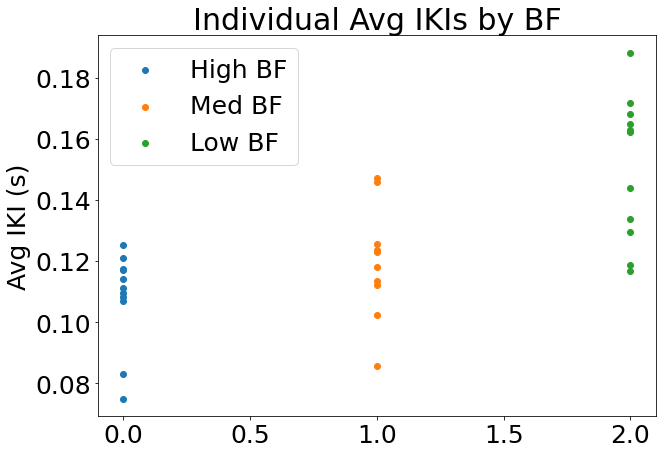

In [19]:
plt.figure(figsize=(10, 7))
highbf_scatter = plt.scatter(([0] * len((avgiki_bysub(highbf_rts)).iloc[:, 1])), avgiki_bysub(highbf_rts).iloc[:, 1], label='High BF')
medbf_scatter = plt.scatter(([1] * len((avgiki_bysub(medbf_rts)).iloc[:, 1])), avgiki_bysub(medbf_rts).iloc[:, 1], label='Med BF')
lowbf_scatter = plt.scatter(([2] * len((avgiki_bysub(lowbf_rts)).iloc[:, 1])), avgiki_bysub(lowbf_rts).iloc[:, 1], label='Low BF')

plt.xlabel("")
plt.ylabel("Avg IKI (s)")
plt.title("Individual Avg IKIs by BF")
plt.legend(loc= "best")

plt.show()

In [20]:
bg_freqs = pd.read_csv('bg_freqs.csv').drop(labels=['Unnamed: 0'], axis=1)
bg_freqs = bg_freqs.sort_values(by='Frequency', ascending=False, ignore_index=True)
bg_freqs[0:60]

Bigrams  Frequency
0       th   22288309
1       he   21484684
2       in   13597302
3       er   12934901
4       an   12315713
5       re   10687711
6       nd    9414961
7       on    8830487
8       ed    7805967
9       ou    7425307
10      ha    6967591
11      it    6637233
12      hi    6198006
13      ti    5135552
14      le    5038239
15      me    4724108
16      ll    4235407
17      be    3798740
18      co    3609272
19      ch    3267507
20      ut    3257233
21      el    3235254
22      ee    2839722
23      ly    2589130
24      ul    2181271
25      ir    2142678
26      em    2039661
27      ld    2012500
28      oo    1933683
29      ol    1804856
30      wo    1723496
31      am    1610395
32      ab    1203849
33      bu    1183063
34      bo    1140702
35      fa    1043958
36      mp    1042198
37      od    1013147
38      up     968744
39      ck     925655
40      rm     905131
41      uc     891233
42      pp     805170
43      ru     705492
44      lu     568081
45      va     560130
46      pu     514720
47      ib     493267
48      ud     458716
49      nk     445067
50      vo     368238
51      dy     360103
52      dd     306083
53      eo     305120
54      oe     270012
55      py     149099
56      bj     105433
57      ka      60568
58      zi      54565
59      nr      54341

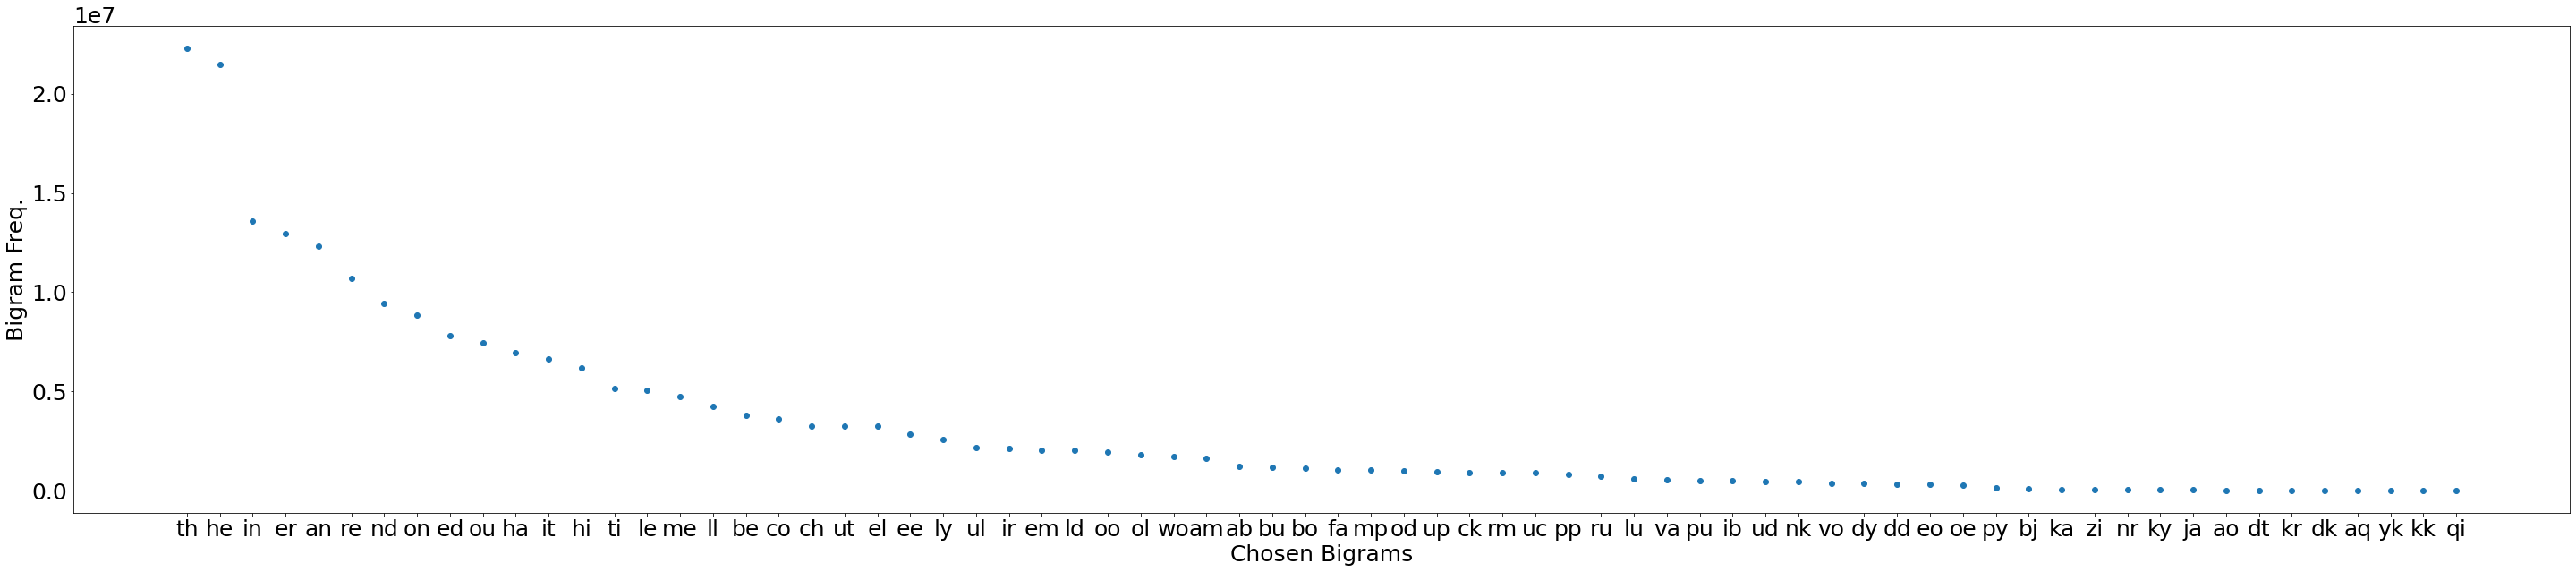

In [21]:
plt.figure(figsize=(50, 10))
bg_freq = plt.scatter(bg_freqs['Bigrams'], bg_freqs['Frequency'])

plt.xlabel("Chosen Bigrams")
plt.ylabel("Bigram Freq.")
plt.title("")

plt.show()

In [22]:
high_bgs = bg_freqs.loc[0:15]
med_bgs = bg_freqs.loc[15:46]
low_bgs = bg_freqs.loc[46:69]

In [23]:
## defining function to organize bigram ikis
def bg_iki_sort(DF, sort_parameter): # DF is all_bgs or corr_trials_bybg, sort_parameter is relevant list of strings
    bg_ikis = []
    bg_strings = []
    for bg in bg_freqs['Bigrams']:
        ikis = [bg]
        strings = [bg]
        for index, data in DF.iterrows():
            if ((DF['bigram'][index]).replace("'", "")).replace(" ", "") == bg and DF['string'][index] in sort_parameter:
                ikis.append(DF['IKI'][index])
                strings.append(DF['string'][index])
        bg_ikis.append(ikis)
        bg_strings.append(strings)
            
    return pd.DataFrame(bg_ikis)
#     bg_strings = pd.DataFrame(bg_strings)

In [24]:
bg_ikis = []
bg_strings = []
for bg in bg_freqs['Bigrams']:
    ikis = [bg]
    strings = [bg]
    for index, data in corr_trials_bybg.iterrows():
        if corr_trials_bybg['bigram'][index] == bg:
            ikis.append(corr_trials_bybg['IKI'][index])
            strings.append(corr_trials_bybg['string'][index])
    bg_ikis.append(ikis)
    bg_strings.append(strings)
    
            
bg_ikis = pd.DataFrame(bg_ikis)
bg_strings = pd.DataFrame(bg_strings)

bg_xvals = []
for n in range(0,70):
    bg_xvals.append([n]*577)
    
bg_xvals = pd.DataFrame(bg_xvals)

In [25]:
bg_stats = []
for index, data in bg_ikis.iterrows():
    bg_stats.append([bg_ikis.iloc[index, 0], bg_ikis.iloc[index, 1:577].mean(), np.std(bg_ikis.iloc[index, 1:577]), variation((bg_ikis.iloc[index, 1:577].tolist()), nan_policy='omit')])
    
bg_stats = pd.DataFrame(bg_stats, columns=['Bigram', 'Mean', 'STD', 'CV'])

with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(bg_stats)

   Bigram      Mean       STD        CV
0      th  0.108682  0.047355  0.435719
1      he  0.127235  0.060988  0.479335
2      in  0.151696  0.043490  0.286692
3      er  0.110337  0.050097  0.454034
4      an  0.188091  0.085707  0.455667
5      re  0.123475  0.164285  1.330505
6      nd  0.135768  0.050194  0.369704
7      on  0.192594  0.074845  0.388615
8      ed  0.202569  0.155813  0.769185
9      ou  0.130811  0.070485  0.538834
10     ha  0.150148  0.105734  0.704197
11     it  0.141052  0.048261  0.342146
12     hi  0.159214  0.065301  0.410147
13     ti  0.140280  0.061448  0.438041
14     le  0.097948  0.027820  0.284026
15     me  0.120170  0.082943  0.690214
16     ll  0.149138  0.020385  0.136687
17     be  0.127031  0.054316  0.427583
18     co  0.193642  0.094487  0.487945
19     ch  0.119609  0.035122  0.293640
20     ut  0.114537  0.037126  0.324137
21     el  0.190899  0.077381  0.405349
22     ee  0.156449  0.026080  0.166698
23     ly  0.138580  0.059475  0.429171


In [28]:
def bgplot_bystr():
    for string in typ.all_strings:
        s = bg_strings[bg_strings.isin([string])].stack()
        L = s.index.tolist()
        xvals = []
        ikis = []
        for i in L:
            xvals.append(bg_xvals.iloc[i])
            ikis.append(bg_ikis.iloc[i])
    rbg = np.random.rand(3,).reshape(1,-1)
    plt.scatter(xvals, ikis, c=rbg)

In [34]:
bg_strings

0      1      2      3      4      5      6      7      8      9    ...  \
0   th  there  therm  edthe  think  think  therm  therm  tithe  therm  ...   
1   he  there  therm  heond  edthe  therm  therm  tithe  therm  cheer  ...   
2   in  think  think  think  think  think  think  think  think  think  ...   
3   er  there  therm  therm  therm  therm  cheer  therm  cheer  cheer  ...   
4   an  vanru  vanru  vanru  vanru  vanru  vanru  vanru  vanru  vanru  ...   
..  ..    ...    ...    ...    ...    ...    ...    ...    ...    ...  ...   
65  dk  vodka  vodka  vodka  vodka  vodka  vodka  vodka  vodka  vodka  ...   
66  aq  faqir  faqir  faqir  faqir  faqir  faqir  faqir  faqir  faqir  ...   
67  yk  pykka  pykka  pykka  pykka  pykka  pykka  pykka  pykka  pykka  ...   
68  kk  pykka  pykka  pykka  pykka  pykka  pykka  pykka  pykka  pykka  ...   
69  qi  faqir  faqir  faqir  faqir  faqir  faqir  faqir  faqir  faqir  ...   

      708    709    710    711    712    713    714    715    716    717  
0    None   None   None   None   None   None   None   None   None   None  
1   therm  there  tithe  edthe  theme  theme  tithe  theme  heond  cheer  
2    None   None   None   None   None   None   None   None   None   None  
3    None   None   None   None   None   None   None   None   None   None  
4    None   None   None   None   None   None   None   None   None   None  
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  
65   None   None   None   None   None   None   None   None   None   None  
66   None   None   None   None   None   None   None   None   None   None  
67   None   None   None   None   None   None   None   None   None   None  
68   None   None   None   None   None   None   None   None   None   None  
69   None   None   None   None   None   None   None   None   None   None  

[70 rows x 718 columns]

In [32]:
## scatter of iki values by bigram and word(color)
plt.figure(figsize=(50, 30))

for string in typ.all_strings:
    s = bg_strings[bg_strings.isin([string])].stack()
    L = s.index.tolist()
    print(L)
    xvals = []
    ikis = []
    for i in L:
        xvals.append(bg_xvals.iloc[i])
        ikis.append(bg_ikis.iloc[i])
    rbg = np.random.rand(3,).reshape(1,-1)
    plt.scatter(xvals, ikis, c=rbg)

plt.xlabel("Chosen Bigrams by Bigram Freq.")
plt.ylabel("IKI (s)")
plt.title("")
plt.xticks(np.arange(70), bg_freqs['Bigrams'])
# plt.legend(loc= "best")
plt.ylim([0, 1])
# plt.ylim([0.04775, 0.04825])

plt.show()

[(0, 1), (0, 15), (0, 18), (0, 20), (0, 26), (0, 34), (0, 36), (0, 41), (0, 49), (0, 59), (0, 62), (0, 63), (0, 68), (0, 76), (0, 85), (0, 94), (0, 101), (0, 102), (0, 107), (0, 109), (0, 115), (0, 117), (0, 127), (0, 148), (0, 150), (0, 152), (0, 156), (0, 160), (0, 166), (0, 168), (0, 184), (0, 191), (0, 192), (0, 195), (0, 204), (0, 205), (0, 214), (0, 216), (0, 227), (0, 230), (0, 231), (0, 236), (0, 237), (0, 249), (0, 256), (0, 258), (0, 264), (0, 280), (0, 287), (0, 290), (0, 297), (0, 311), (0, 312), (0, 318), (0, 319), (0, 322), (0, 339), (0, 343), (0, 352), (0, 355), (0, 368), (0, 380), (0, 391), (0, 393), (0, 395), (0, 400), (0, 402), (0, 412), (0, 417), (0, 425), (0, 429), (0, 441), (0, 443), (0, 454), (0, 456), (0, 464), (0, 467), (0, 470), (0, 472), (0, 480), (0, 492), (0, 496), (0, 501), (0, 502), (0, 516), (0, 528), (0, 538), (0, 541), (0, 546), (0, 548), (0, 563), (0, 564), (0, 569), (0, 575), (0, 578), (0, 579), (0, 582), (0, 591), (0, 599), (1, 1), (1, 16), (1, 19), 

IndexError: single positional indexer is out-of-bounds

<Figure size 3600x2160 with 0 Axes>

In [35]:
## scatter of iki values by bigram and word
plt.figure(figsize=(50, 20))

string = 'there'

s = bg_strings[bg_strings.isin([string])].stack()
L = s.index.tolist()
xvals = []
ikis = []
for i in L:
    xvals.append(bg_xvals.iloc[i])
    ikis.append(bg_ikis.iloc[i])
rbg = np.random.rand(3,).reshape(1,-1)
plt.scatter(xvals, ikis, c=rbg)

plt.xlabel("Chosen Bigrams by Bigram Freq.")
plt.ylabel("IKI (s)")
plt.title("")
plt.xticks(np.arange(70), bg_freqs['Bigrams'])
# plt.legend(loc= "best")
plt.ylim([0, 0.5])
# plt.ylim([0.04775, 0.04825])

plt.show()

IndexError: single positional indexer is out-of-bounds

<Figure size 3600x1440 with 0 Axes>

In [36]:
## scatter of iki values by bigram and word
plt.figure(figsize=(50, 20))

string = 'tithe'

s = bg_strings[bg_strings.isin([string])].stack()
L = s.index.tolist()
xvals = []
ikis = []
for i in L:
    xvals.append(bg_xvals.iloc[i])
    ikis.append(bg_ikis.iloc[i])
rbg = np.random.rand(3,).reshape(1,-1)
plt.scatter(xvals, ikis, c=rbg)

plt.xlabel("Chosen Bigrams by Bigram Freq.")
plt.ylabel("IKI (s)")
plt.title("")
plt.xticks(np.arange(70), bg_freqs['Bigrams'])
# plt.legend(loc= "best")
plt.ylim([0, 1])
# plt.ylim([0.04775, 0.04825])

plt.show()

IndexError: single positional indexer is out-of-bounds

<Figure size 3600x1440 with 0 Axes>

In [257]:
## defining functions that calculate individual IKI means and CVs for a particular bigram in a defined string
##### these need to be edited to include changable dataframe like the other functions

def indiv_means_bybg(string, bigram):
    DF = tight_bgs.query('string == @string and bigram == @bigram')
    means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean']))
    return means

def indiv_cvs_bybg(string, bigram):
    DF = tight_bgs.query('string == @string and bigram == @bigram')
    cvs = pd.DataFrame(DF.groupby('sID').IKI.agg([variation]))
    return cvs

## defining functions that calculate indivdual IKI means and Avg. CVS by word and bigram groupings

def indiv_means(dataframe, str_or_bg, sort_type): ## str_or_bg can be 'string' or 'bigram'
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    else:
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean']))
    means.columns = ['Avg IKI']
    return means

def indiv_avgcvs(dataframe, str_or_bg, sort_type):
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    else:
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    cvs = DF.groupby(['sID', str_or_bg]).IKI.agg([variation])
    avg_cvs = pd.DataFrame(cvs.groupby('sID').variation.agg(['mean']))
    avg_cvs.columns = ['Avg CV IKI']
    return avg_cvs

def indiv_avgsds(dataframe, str_or_bg, sort_type):
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    else:
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    sds = DF.groupby(['sID', str_or_bg]).IKI.agg(['std'])
    sds = sds.rename(columns={'std':'sd'})
    avg_sds = pd.DataFrame(sds.groupby('sID').sd.agg(['mean']))
    avg_sds.columns = ['Avg SD IKI']
    return avg_sds

def indiv_error(dataframe, str_or_bg, sort_type):
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    else:
        print('please select "string" or "bigram"')
    errs = DF.groupby(['sID', str_or_bg]).size()
    avg_err = errs.groupby('sID').agg(['sum'])
#     print(type(avg_err))
    avg_err.columns = ['Total Error']
#     print(errs)
#     print(avg_err)
    return avg_err

In [259]:
indiv_error(incorr_bgs, 'string', typ.medwf)
# incorr_trials

Total Error
sID              
s175            7
s178           13
s179           11
s180            3
s181            3
s182            2
s183           26
s189            4
s190           10
s20            18
s83             3

In [251]:
# indiv_error_bybg('there', 'th')
# # indiv_cvs_bybg('there', 'th')
# incorr_trials_bybg[incorr_trials_bybg['string'] == 'there']

In [40]:
# def indiv_means_strtype(str_type):
#     means = pd.DataFrame()
#     DF = tight_bgs[tight_bgs.string.isin(str_type)]
#     for sID in ID_list:
#         indiv = DF[DF['sID'] == sID]
#         means = means.append({'ID':sID, 'Words/Bigrams Used':str_type, 'Avg IKI':(indiv['IKI']).mean()}, ignore_index=True)
#     return means

# def indiv_cvs_strtype(str_type):
#     cvs = pd.DataFrame()
#     DF = tight_bgs[tight_bgs.string.isin(str_type)]
#     for sID in ID_list:
#         indiv = DF[DF['sID'] == sID]
#         cvs = cvs.append({'ID':sID, 'Words/Bigrams Used':str_type, 'CV IKI':variation(indiv['IKI'])}, ignore_index=True)
#     return cvs

# def indiv_means_bgtype(bg_type):
#     means = pd.DataFrame()
#     DF = tight_bgs[tight_bgs.bigram.isin(bg_type)]
#     for sID in ID_list:
#         indiv = DF[DF['sID'] == sID]
#         means = means.append({'ID':sID, 'Words/Bigrams Used':bg_type, 'Avg IKI':(indiv['IKI']).mean()}, ignore_index=True)
#     return means

# def indiv_cvs_bgtype(bg_type):
#     cvs = pd.DataFrame()
#     DF = tight_bgs[tight_bgs.bigram.isin(bg_type)]
#     for sID in ID_list:
#         indiv = DF[DF['sID'] == sID]
#         cvs = cvs.append({'ID':sID, 'Words/Bigrams Used':bg_type, 'CV IKI':variation(indiv['IKI'])}, ignore_index=True)
#     return cvs

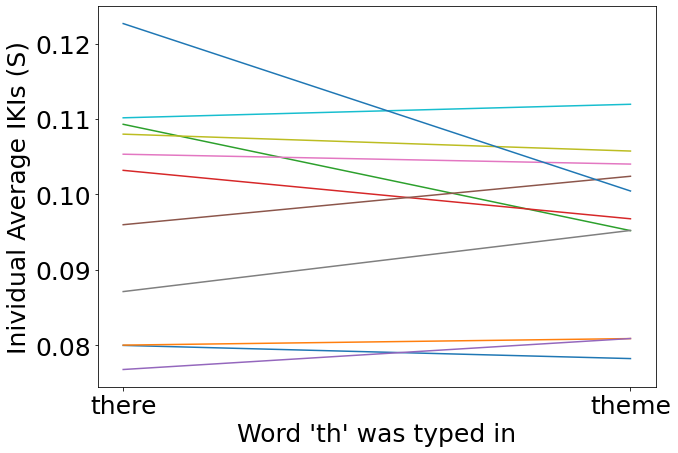

In [41]:
## plot comparing indidivuals' average IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_means_bybg('there', 'th')['mean'], indiv_means_bybg('theme', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

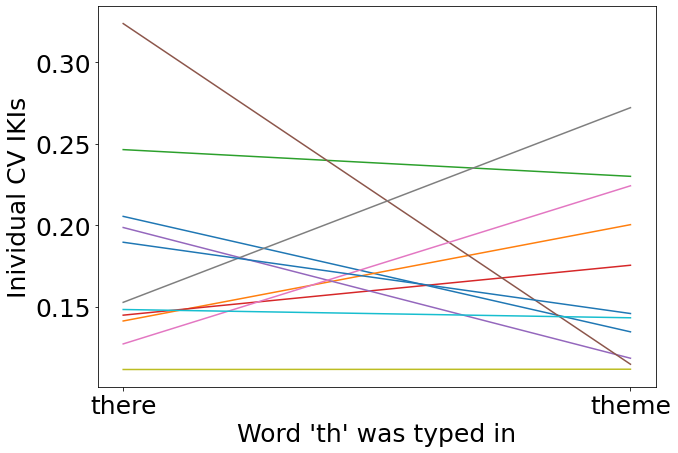

In [42]:
## plot comparing indidivuals' CV IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('theme', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

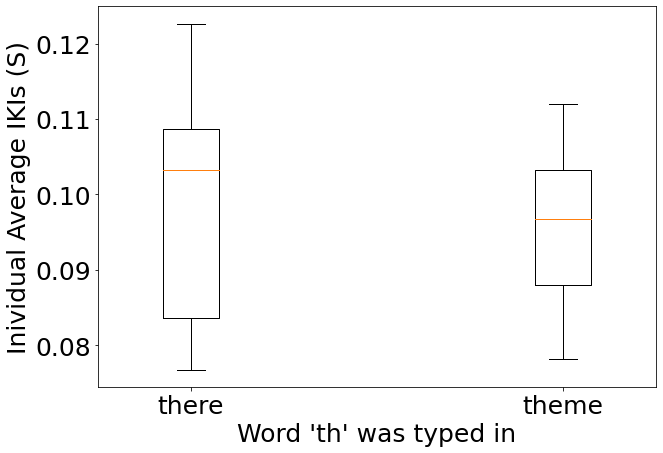

In [43]:
## box plot comparing indidivuals' average IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_means_bybg('there', 'th')['mean'], indiv_means_bybg('theme', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.boxplot(D, positions=x)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

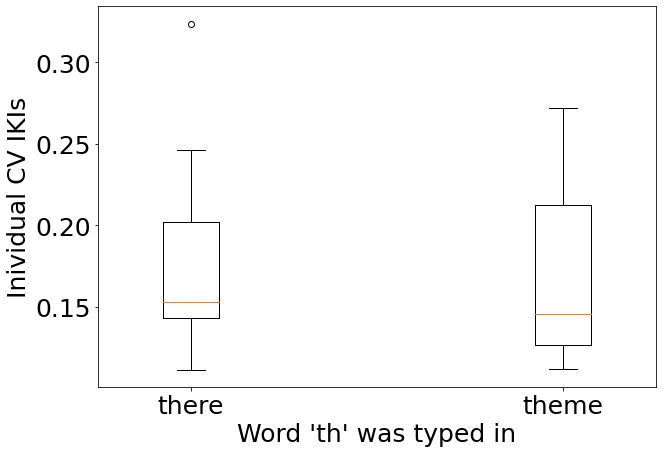

In [44]:
## box plot comparing indidivuals' CV IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('theme', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.boxplot(D, positions=x)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

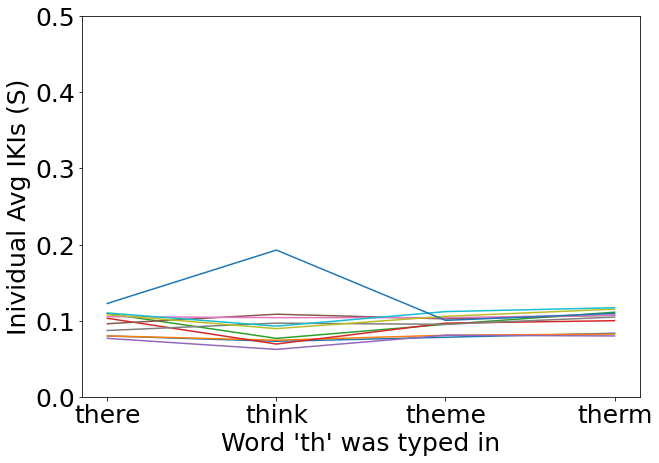

In [45]:
x = [2, 4, 6, 8]
D = (indiv_means_bybg('there', 'th')['mean'], indiv_means_bybg('think', 'th')['mean'], 
     indiv_means_bybg('theme', 'th')['mean'], indiv_means_bybg('therm', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'think', 'theme', 'therm'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Avg IKIs (S)")
plt.ylim([0, 0.5])
plt.title("")
# plt.legend(loc="best")

plt.show()

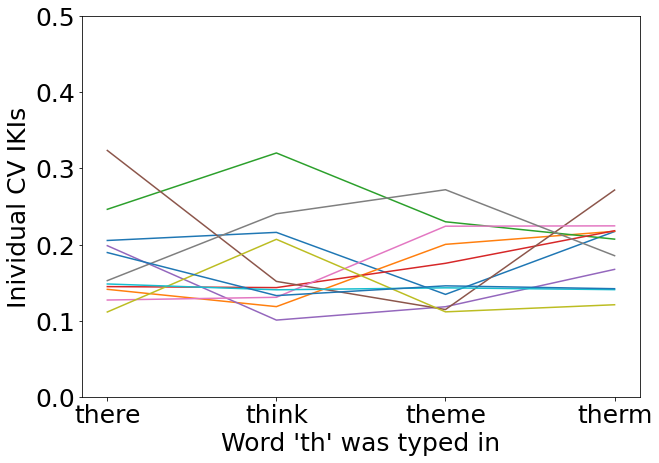

In [46]:
x = [2, 4, 6, 8]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('think', 'th')['variation'], 
     indiv_cvs_bybg('theme', 'th')['variation'], indiv_cvs_bybg('therm', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'think', 'theme', 'therm'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
plt.ylim([0, 0.5])
plt.title("")
# plt.legend(loc="best")

plt.show()

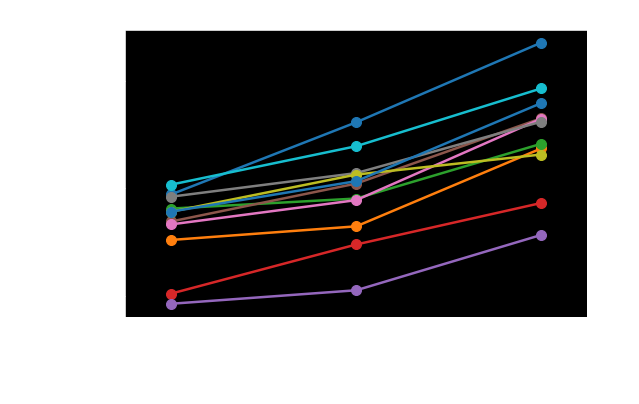

In [76]:
## individual IKI means by word bf category
x = [2, 4, 6]
D = (indiv_means(tight_bgs, 'string', typ.highbf)['Avg IKI'], 
     indiv_means(tight_bgs, 'string', typ.medbf)['Avg IKI'], 
     indiv_means(tight_bgs, 'string', typ.lowbf)['Avg IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 2.5, ms = 20 )

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('High BF', 'Med BF', 'Low BF'))
plt.xlabel("Average Bigram Frequency Category", labelpad=15)

plt.ylabel("Individual Avg. IKIs (s)", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

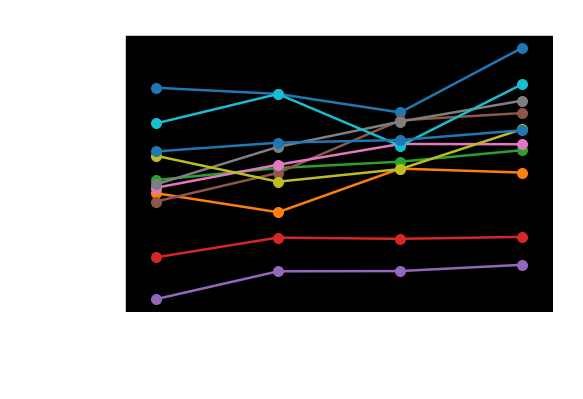

In [77]:
## individual IKI means by WF category
x = [2, 4, 6, 8]
D = (indiv_means(tight_bgs, 'string', typ.highwf)['Avg IKI'], 
     indiv_means(tight_bgs, 'string', typ.medwf)['Avg IKI'], 
     indiv_means(tight_bgs, 'string', typ.lowwf)['Avg IKI'],
    indiv_means(tight_bgs, 'string', typ.pseudo)['Avg IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 2.5, ms = 20 )

plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('High', 'Med', 'Low', 'Pseudo'))
plt.xlabel("Word Frequency Category", labelpad=15)

plt.ylabel("Individual Avg. IKIs (s)", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

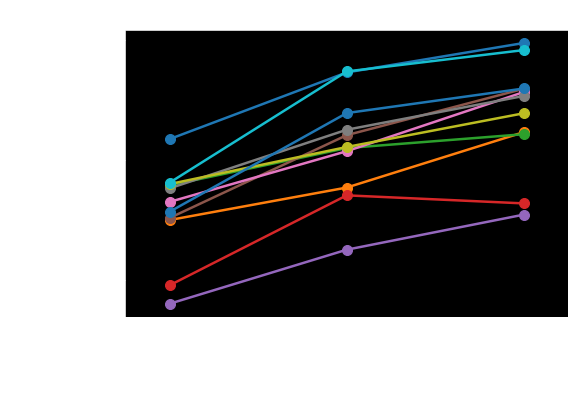

In [78]:
## individual IKI means by bf
plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_means(tight_bgs, 'bigram', high_bgs['Bigrams'])['Avg IKI'], 
     indiv_means(tight_bgs, 'bigram', med_bgs['Bigrams'])['Avg IKI'],
     indiv_means(tight_bgs, 'bigram', low_bgs['Bigrams'])['Avg IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 2.5, ms = 20 )

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('High BF', 'Med BF', 'Low BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)

plt.ylabel("Individual Avg. IKIs (s)", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()


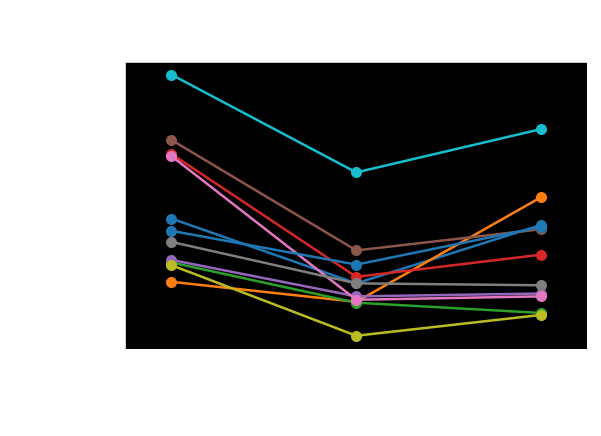

In [88]:
## using bigrams sorted by bf (can specify dataframe, so can look at including errors and not only 2sds)
x = [2, 4, 6]
D = (indiv_avgcvs(tight_bgs, 'bigram', high_bgs['Bigrams'])['Avg CV IKI'], 
     indiv_avgcvs(tight_bgs, 'bigram', med_bgs['Bigrams'])['Avg CV IKI'], 
     indiv_avgcvs(tight_bgs, 'bigram', low_bgs['Bigrams'])['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 2.5, ms = 20 )

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('High BF', 'Med BF', 'Low BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)

plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

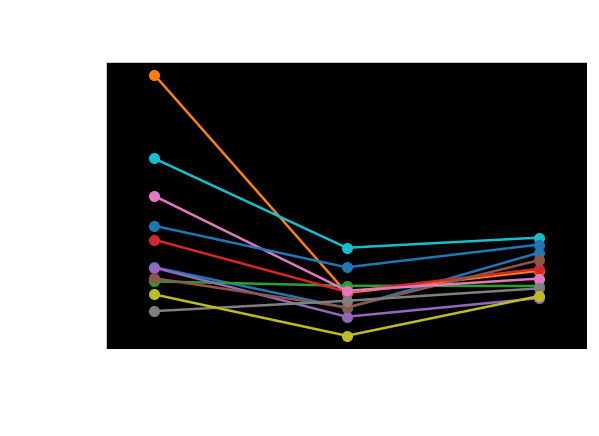

In [87]:
## using bigrams sorted by bigram BF (correct and within 2sd)
x = [2, 4, 6]
D = (indiv_avgcvs(all_bigrams, 'bigram', high_bgs['Bigrams'])['Avg CV IKI'], 
     indiv_avgcvs(all_bigrams, 'bigram', med_bgs['Bigrams'])['Avg CV IKI'], 
     indiv_avgcvs(all_bigrams, 'bigram', low_bgs['Bigrams'])['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 2.5, ms = 20 )

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('High BF', 'Med BF', 'Low BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)

plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

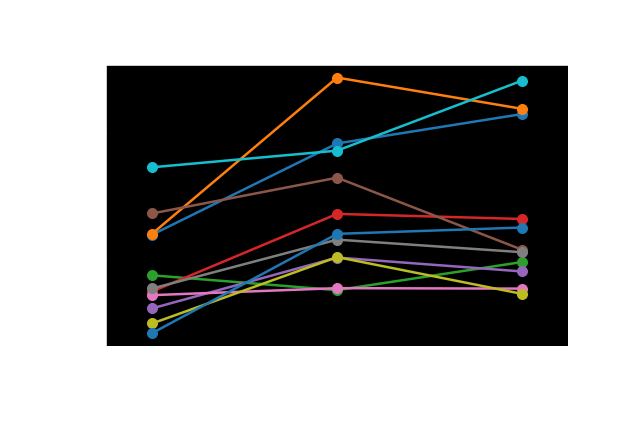

In [90]:
# individual avg CV IKIs by word BF (currently using tight_bgs df)
x = [2, 4, 6]
D = (indiv_avgcvs(tight_bgs, 'string', typ.highbf)['Avg CV IKI'], 
     indiv_avgcvs(tight_bgs, 'string', typ.medbf)['Avg CV IKI'], 
     indiv_avgcvs(tight_bgs, 'string', typ.lowbf)['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 2.5, ms = 20 )

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('High BF', 'Med BF', 'Low BF'))
plt.xlabel("Average Bigram Frequency Category", labelpad=15)

plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

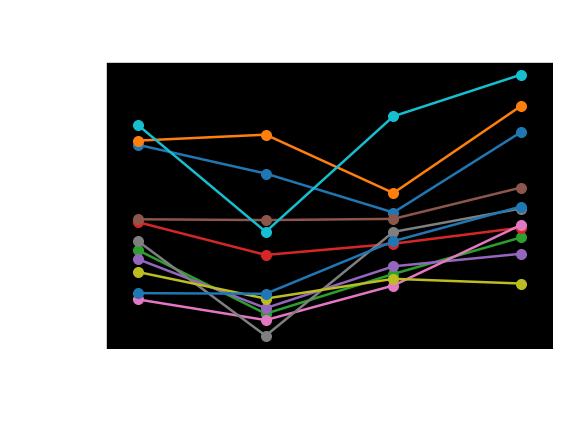

In [82]:
## individual avg CV IKI by WF category (can also change dataframe here)
x = [2, 4, 6, 8]
D = (indiv_avgcvs(tight_bgs, 'string', typ.highwf)['Avg CV IKI'], 
     indiv_avgcvs(tight_bgs, 'string', typ.medwf)['Avg CV IKI'], 
     indiv_avgcvs(tight_bgs, 'string', typ.lowwf)['Avg CV IKI'],
     indiv_avgcvs(tight_bgs, 'string', typ.pseudo)['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 2.5, ms = 20 )

plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('High', 'Med', 'Low', 'Pseudo'))
plt.xlabel("Word Frequency Category", labelpad=15)

plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

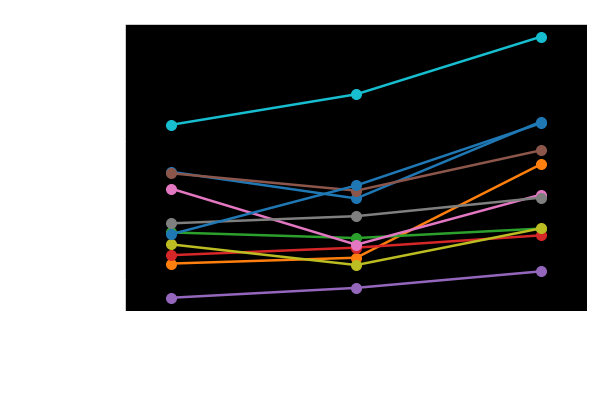

In [83]:
## individual average std by bigram bf (can change filtering via df)
plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_avgsds(tight_bgs, 'bigram', high_bgs['Bigrams'])['Avg SD IKI'], 
     indiv_avgsds(tight_bgs, 'bigram', med_bgs['Bigrams'])['Avg SD IKI'],
     indiv_avgsds(tight_bgs, 'bigram', low_bgs['Bigrams'])['Avg SD IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 2.5, ms = 20 )

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('High BF', 'Med BF', 'Low BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Indiv. Avg. STD IKI (s)", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('indiv_avgsds.png', dpi=300)
plt.show()

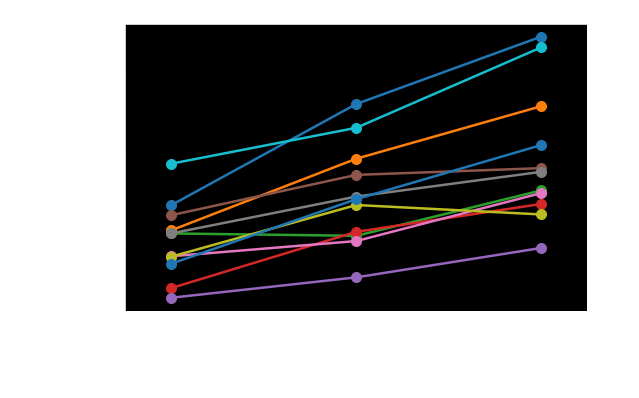

In [84]:
## individual average std by bigram bf (can change filtering via df)
plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_avgsds(tight_bgs, 'string', typ.highbf)['Avg SD IKI'], 
     indiv_avgsds(tight_bgs, 'string', typ.medbf)['Avg SD IKI'],
     indiv_avgsds(tight_bgs, 'string', typ.lowbf)['Avg SD IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 2.5, ms = 20 )

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('High BF', 'Med BF', 'Low BF'))
plt.xlabel("Average Bigram Frequency Category", labelpad=15)
plt.ylabel("Indiv. Avg. STD IKI (s)", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('indiv_avgsds.png', dpi=300)
plt.show()

(sID
s175    0.072968
s178    0.057322
s179    0.045364
s180    0.039342
s181    0.030030
s182    0.045135
s183    0.037664
s189    0.045437
s190    0.045464
s20     0.071049
s83     0.042313
Name: Avg SD IKI, dtype: float64, sID
s175    0.068929
s178    0.054763
s179    0.038718
s180    0.038754
s181    0.028121
s182    0.049369
s183    0.037535
s189    0.036988
s190    0.039100
s20     0.058579
s83     0.044177
Name: Avg SD IKI, dtype: float64, sID
s175    0.058098
s178    0.053856
s179    0.044216
s180    0.039889
s181    0.034114
s182    0.055235
s183    0.043125
s189    0.054768
s190    0.043728
s20     0.067716
s83     0.051219
Name: Avg SD IKI, dtype: float64, sID
s175    0.079236
s178    0.065669
s179    0.050927
s180    0.040817
s181    0.034908
s182    0.061815
s183    0.051113
s189    0.060469
s190    0.045705
s20     0.084063
s83     0.057993
Name: Avg SD IKI, dtype: float64)


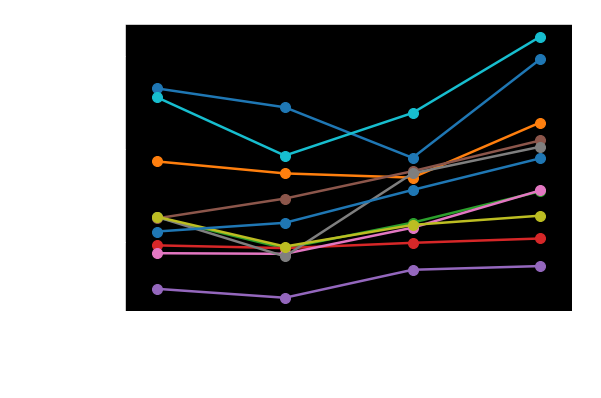

In [229]:
## individual average std by wf (can change filtering via df)
plt.rcParams['font.size'] = '30'
x = [2, 4, 6, 8]
D = (indiv_avgsds(tight_bgs, 'string', typ.highwf)['Avg SD IKI'], 
     indiv_avgsds(tight_bgs, 'string', typ.medwf)['Avg SD IKI'],
     indiv_avgsds(tight_bgs, 'string', typ.lowwf)['Avg SD IKI'],
     indiv_avgsds(tight_bgs, 'string', typ.pseudo)['Avg SD IKI'])

print(D)

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 2.5, ms = 20 )

plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('High', 'Med', 'Low', 'Pseudo'))
plt.xlabel("Word Frequency Category", labelpad=15)
plt.ylabel("Indiv. Avg. STD IKI (s)", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('indiv_avgsds.png', dpi=300)
plt.show()

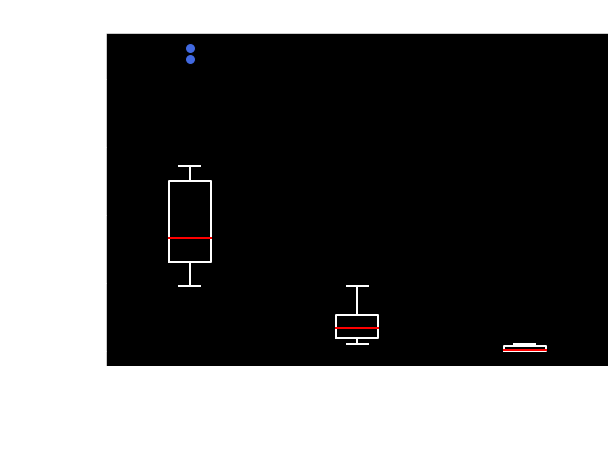

In [56]:
## plotting BF distribution of data set
x = [2, 4, 6]
D = (high_bgs['Frequency'], med_bgs['Frequency'], low_bgs['Frequency'])

fig, ax = plt.subplots(figsize=(9.25, 7))

boxprops = dict(linestyle='-', linewidth=2, color = 'white')
whiskerprops = dict(linewidth=2, color = 'white')
capprops = dict(linewidth=2, color = 'white')
flierprops = dict(markerfacecolor='royalblue', markersize=10)
medianprops = dict(linewidth=2, color='red')

ax.boxplot(D, positions=x, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
          flierprops=flierprops, medianprops=medianprops)

plt.xlim([1, 7])
plt.xticks(x, ('High BF', 'Med BF', 'Low BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)

# plt.ylim([0, 0.8])
plt.ylabel("Bigram Frequency", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('wf.png', dpi=300)
plt.show()

In [223]:
list(indiv_error(incorr_trials, 'string', typ.highwf).astype(float)['Total Error'].astype(float))

[6.0, 2.0, 3.0, 4.0, 1.0, 7.0, 8.0, 1.0, 6.0, 2.0]

[2, 4, 6, 8]
(sID
s175    6
s178    2
s179    3
s180    4
s181    1
s182    7
s183    8
s189    1
s20     6
s83     2
Name: Total Error, dtype: int64, sID
s175     5
s178     3
s179     6
s180     2
s181     1
s182     1
s183     8
s189     2
s190     2
s20     12
s83      1
Name: Total Error, dtype: int64, sID
s175     2
s178    10
s179     2
s180     4
s181     4
s182     4
s183     6
s189     1
s190     1
s20     13
s83      3
Name: Total Error, dtype: int64, sID
s175    11
s178     4
s179     6
s180     7
s181     1
s182     3
s183     8
s190     1
s20      8
s83      6
Name: Total Error, dtype: int64)
[10, 11, 11, 10]


ValueError: setting an array element with a sequence.

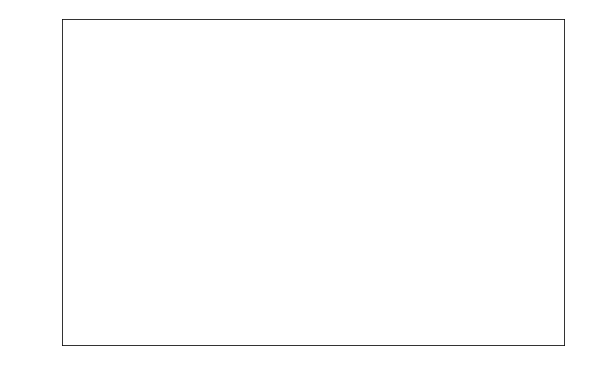

In [232]:
## plotting total trial error by WF
plt.rcParams['font.size'] = '30'
x = [2, 4, 6, 8]

D = (indiv_error(incorr_trials, 'string', typ.highwf)['Total Error'], 
     indiv_error(incorr_trials, 'string', typ.medwf)['Total Error'],
     indiv_error(incorr_trials, 'string', typ.lowwf)['Total Error'],
     indiv_error(incorr_trials, 'string', typ.pseudo)['Total Error'])


fig, ax = plt.subplots(figsize=(9, 6))

print(x)
print(D)
print([len(x) for x in D])
ax.plot(x, D, '.-', linewidth = 2.5, ms = 20)

plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('High', 'Med', 'Low', 'Pseudo'))
plt.xlabel("Word Frequency Category", labelpad=15)
plt.ylabel("Indiv. Total Error", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_avgsds.png', dpi=300)
plt.show()

[2, 4, 6] (sID
s175     7
s178    10
s179     4
s180     2
s181     5
s182     6
s183     9
s189     2
s190     1
s20      8
s83      6
Name: Total Error, dtype: int64, sID
s175     6
s178     5
s179     3
s180     7
s181     1
s182     5
s183    10
s189     1
s190     1
s20     18
s83      2
Name: Total Error, dtype: int64, sID
s175    11
s178     4
s179    10
s180     8
s181     1
s182     4
s183    11
s189     1
s190     2
s20     13
s83      4
Name: Total Error, dtype: int64)
[11, 11, 11]


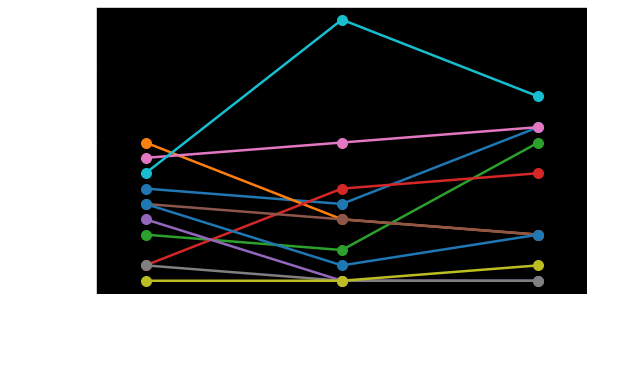

In [233]:
## plotting total trial error by word BF
plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_error(incorr_trials, 'string', typ.highbf)['Total Error'], 
     indiv_error(incorr_trials, 'string', typ.medbf)['Total Error'],
     indiv_error(incorr_trials, 'string', typ.lowbf)['Total Error'])

fig, ax = plt.subplots(figsize=(9, 6))

print(x, D)
print([len(x) for x in D])
ax.plot(x, D, '.-', linewidth = 2.5, ms = 20)

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('High BF', 'Med BF', 'Low BF'))
plt.xlabel("Average Bigram Frequency Category", labelpad=15)
plt.ylabel("Indiv. Total Error", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('indiv_avgsds.png', dpi=300)
plt.show()

ValueError: setting an array element with a sequence.

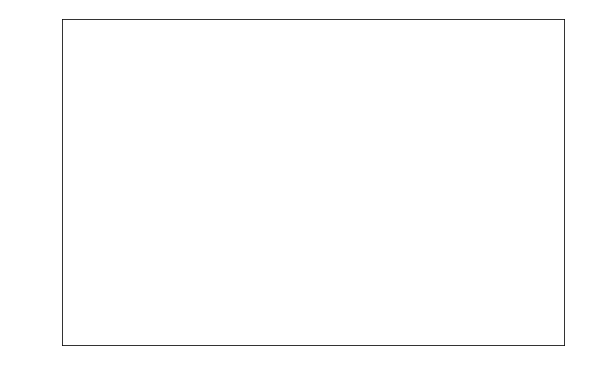

In [179]:
## plotting total trial error by bigram BF
plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_error(incorr_bgs, 'bigram', high_bgs['Bigrams'])['Total Error'], 
     indiv_error(incorr_bgs, 'bigram', med_bgs['Bigrams'])['Total Error'],
     indiv_error(incorr_bgs, 'bigram', low_bgs['Bigrams'])['Total Error'])

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 2.5, ms = 20 )

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('High BF', 'Med BF', 'Low BF'))
plt.xlabel("Average Word Bigram Frequency Category", labelpad=15)
plt.ylabel("Indiv. Total Error", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('indiv_avgsds.png', dpi=300)
plt.show()

In [189]:
## running wilcoxen rank-sum test between IKI and CV IKI
ranksums(indiv_means(tight_bgs, 'bigram', high_bgs['Bigrams'])['Avg IKI'], 
         indiv_avgcvs(tight_bgs, 'bigram', high_bgs['Bigrams'])['Avg CV IKI'])

ranksums(indiv_means(all_bigrams, 'bigram', high_bgs['Bigrams'])['Avg IKI'],
         indiv_avgcvs(all_bigrams, 'bigram', high_bgs['Bigrams'])['Avg CV IKI'])

RanksumsResult(statistic=-3.9727331518303837, pvalue=7.105263288600155e-05)

In [58]:
def delta_iki(bigram, string):
    all_deltas = []
    for sub in ID_list:
        sub_df = tight_bgs[(tight_bgs.sID == sub) & (tight_bgs.bigram == bigram) & (tight_bgs.string == string)]
        deltas = [sub]
        for trial in range(0, len(sub_df) - 1):
            deltas.append(sub_df.loc[trial + 1, 'IKI'] - sub_df.loc[trial, 'IKI']) ## depends on column position
        all_deltas.append(deltas)
    all_deltas = pd.DataFrame(all_deltas)
    all_deltas = all_deltas.transpose()
    return all_deltas

In [59]:
def iki_change_bysub(bigram, string):
    all_subs = pd.DataFrame()
    for sub in ID_list:
        sub_df = tight_bgs[(tight_bgs.sID == sub) & (tight_bgs.bigram == bigram) & (tight_bgs.string == string)]
        ikis = sub_df['IKI'].tolist()
        while len(ikis) != 10:
            ikis.append(np.nan)
        all_subs[sub] = ikis
    return all_subs
        
iki_change_bysub('pu', 'puppy')

s83       s20      s175      s178      s179      s180      s181  \
0  0.231904  0.408087  0.343962  0.224006  0.120019  0.271988  0.143999   
1  0.215963  0.248033  0.327963  0.200019  0.104102  0.215993  0.127966   
2  0.223882  0.255958  0.376076  0.232031  0.135959  0.248098  0.144044   
3  0.351879  0.191992  0.288030  0.232091  0.135991  0.232011  0.159881   
4  0.231981  0.303972  0.296061  0.231961  0.143982  0.239925  0.136032   
5  0.184043  0.304059  0.288034  0.247928  0.120058  0.264041  0.127971   
6  0.224068       NaN       NaN  0.248023  0.136023       NaN  0.127974   
7  0.352076       NaN       NaN  0.200118       NaN       NaN  0.103916   
8  0.191886       NaN       NaN  0.215977       NaN       NaN  0.104077   
9  0.144011       NaN       NaN  0.320057       NaN       NaN  0.127982   

       s182      s183      s189      s190  
0  0.287967  0.256007  0.144089  0.232077  
1  0.183987  0.256057  0.183954  0.296108  
2  0.143998  0.239998  0.215990  0.232096  
3  0.080093  0.247948  0.136088  0.296070  
4  0.167891  0.311919  0.152019  0.296004  
5  0.159959  0.272032  0.168022       NaN  
6  0.135992  0.271979  0.159964       NaN  
7  0.111993  0.272057  0.168006       NaN  
8  0.135979       NaN  0.143896       NaN  
9  0.103863       NaN       NaN       NaN

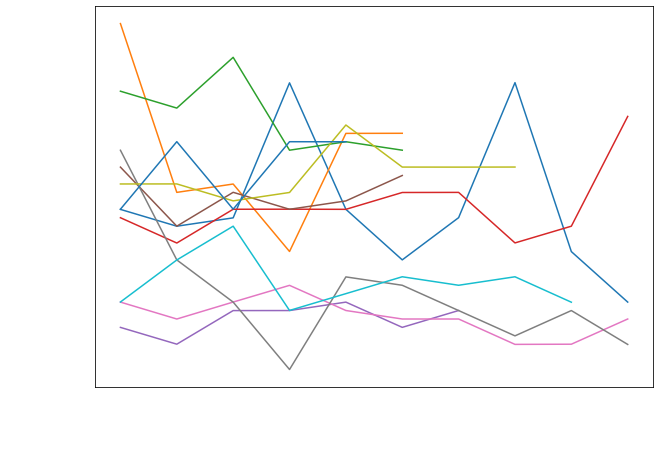

In [60]:
##plotting IKI accross repetitions for each individual

df = iki_change_bysub('pu', 'puppy')

df.plot(figsize=(10, 7))

# plt.xticks(ticks = (1, 2, 3, 4, 5 ,6 ,7, 8), labels=('1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9'))
plt.xlabel("Repetition #")
plt.ylabel("IKI (s)")
# plt.ylim([0, 0.8])
plt.title("")
plt.legend().remove()

plt.show()

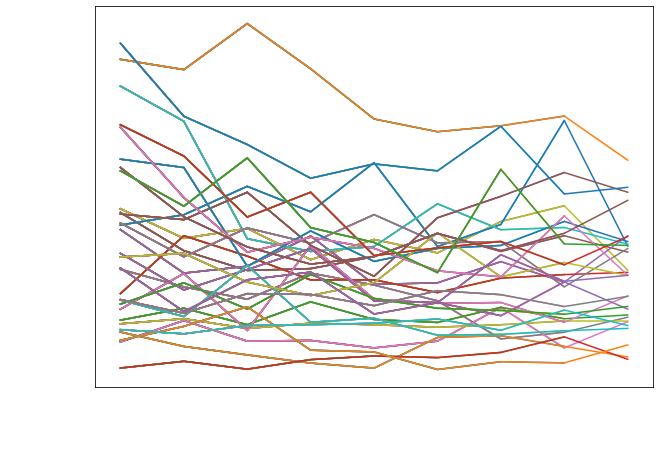

In [61]:
## plotting average IKI for a particular bigram in a particular word across repetitions (for correct trials only)

plt.figure(figsize=(10, 7))
for bg in typ.lowbf_bgs:
    by_bg = corr_trials_bybg[corr_trials_bybg.bigram == bg]
    rep_ikis = []
    for n in range(0, 9):
        all_reps = by_bg[by_bg['rep #'] == n]
        avg_iki_byrep = all_reps['IKI'].mean()
        rep_ikis.append(avg_iki_byrep)

        plt.plot(rep_ikis)

        # plt.xticks(ticks = (1, 2, 3, 4, 5 ,6 ,7, 8), labels=('1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9'))
        plt.xlabel("Repetition #")
        plt.ylabel("Avg IKI (s)")
        # plt.ylim([0, 0.8])
        plt.title("")
        # plt.legend().remove()

plt.show()

In [62]:
yk_df = delta_iki('dk', 'vodka')[1:]

yk_df.plot(figsize=(10, 7))

# plt.xticks(ticks = (1, 2, 3, 4, 5 ,6 ,7, 8), labels=('1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9'))
plt.xlabel("Inter-repetition position")
plt.ylabel("Delta IKI (s)")
# plt.ylim([0, 0.8])
plt.title("")
plt.legend(loc="best")

plt.show()

KeyError: 1

In [63]:
def indiv_means_bgonly(bigram):
    means = pd.DataFrame()
    DF = tight_bgs[tight_bgs['bigram'] == bigram]
    for sID in ID_list:
        indiv = DF[DF['sID'] == sID]
        means = means.append({'ID':sID, 'bigram':bigram, 'Avg IKI':(indiv['IKI']).mean()}, ignore_index=True)
    return means

def indiv_cvs_bgonly(bigram):
    cvs = pd.DataFrame()
    DF = tight_bgs[tight_bgs['bigram'] == bigram]
    for sID in ID_list:
        indiv = DF[DF['sID'] == sID]
        cvs = cvs.append({'ID':sID, 'bigram':bigram, 'CV IKI':variation(indiv['IKI'])}, ignore_index=True)
    return cvs

In [64]:
all_indiv_means = pd.DataFrame()
for bigram in bg_freqs['Bigrams']:
    all_indiv_means = all_indiv_means.append(indiv_means_bgonly(bigram), ignore_index=True).dropna(axis = 0)

all_indiv_cvs = pd.DataFrame()
for bigram in bg_freqs['Bigrams']:
    all_indiv_cvs = all_indiv_cvs.append(indiv_cvs_bgonly(bigram), ignore_index=True).dropna(axis = 0)

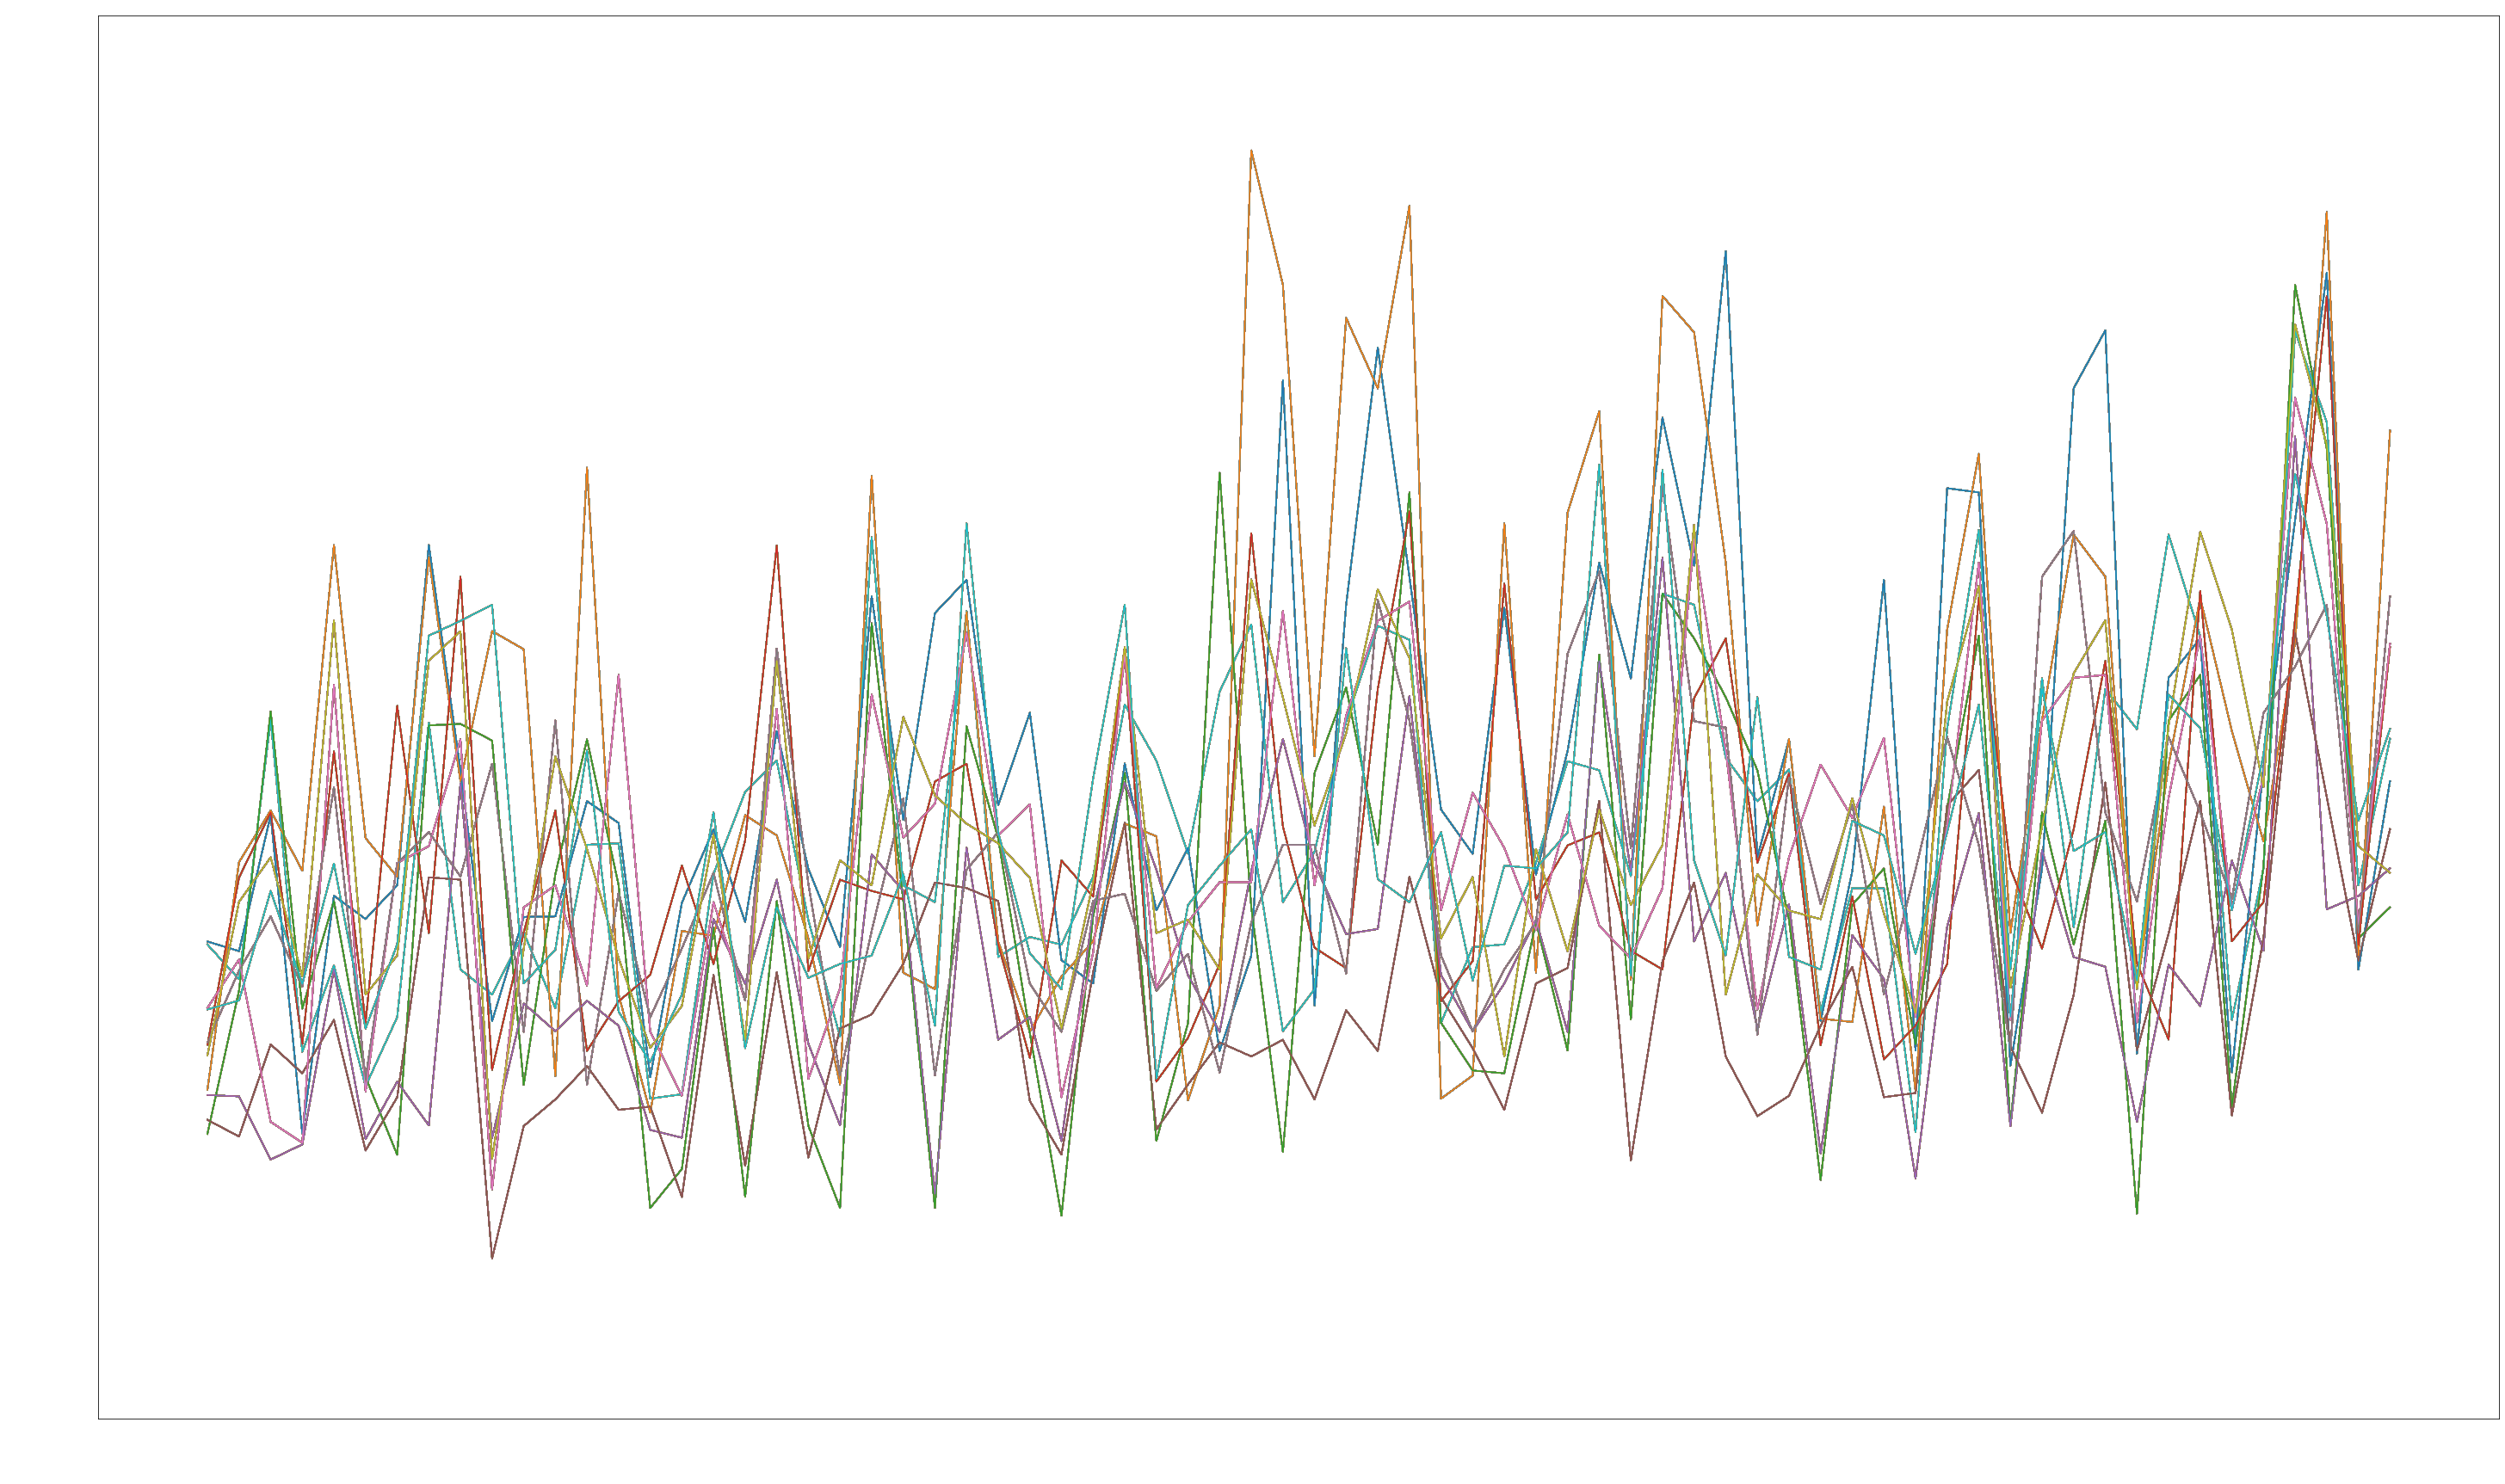

In [65]:
## plot of individual avg iki values by bigram

fig, ax = plt.subplots(figsize=(50, 30))

for bigram in bg_freqs['Bigrams']:
    for sub in ID_list:
        bg_df = all_indiv_means[all_indiv_means.ID == sub]
    # bg_df = all_indiv_means[all_indiv_means.ID == 83]
        ax.plot(bg_df['bigram'], bg_df['Avg IKI'])

plt.xlabel("Chosen Bigrams by Bigram Freq.")
plt.ylabel("Avg Individual IKI (s)")
plt.title("")
plt.xticks(np.arange(70), bg_df['bigram'])
# plt.legend(loc= "best")
plt.ylim([0, 0.4])
# plt.ylim([0.04775, 0.04825])

plt.show()

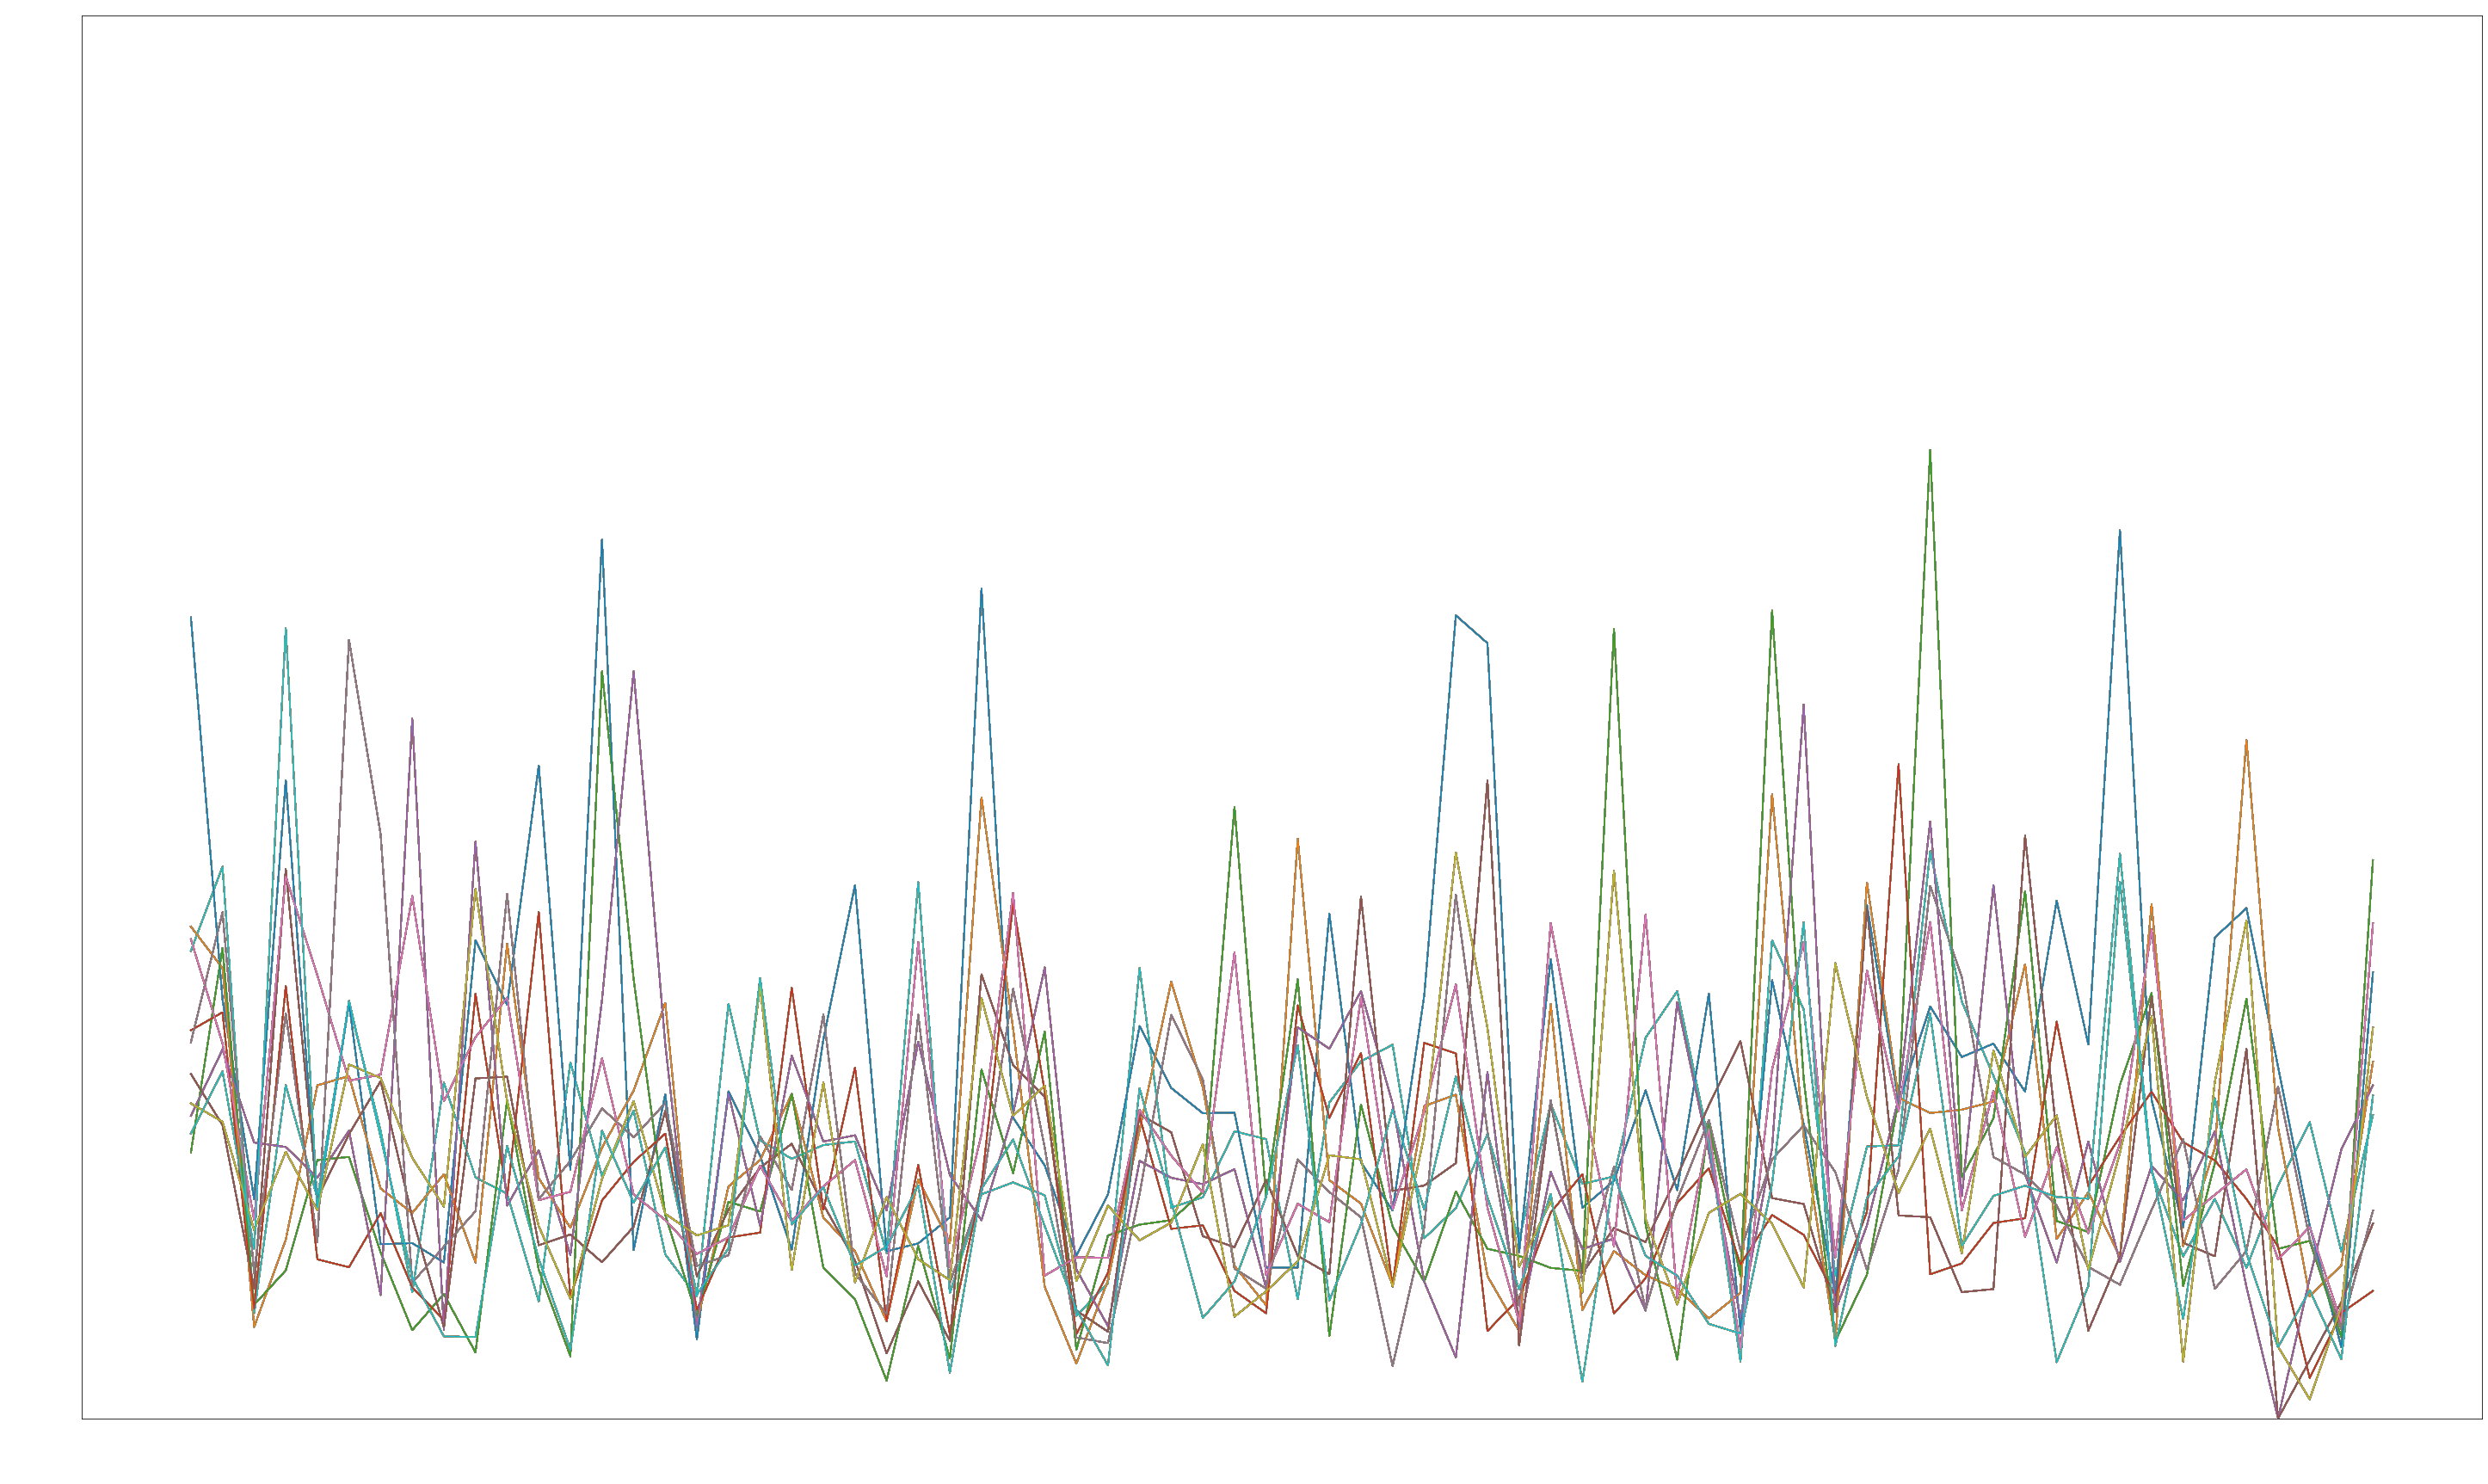

In [66]:
## plot of individual cv iki values by bigram

fig, ax = plt.subplots(figsize=(50, 30))

for bigram in bg_freqs['Bigrams']:
    for sub in ID_list:
        bg_df = all_indiv_cvs[all_indiv_cvs.ID == sub]
    # bg_df = all_indiv_means[all_indiv_means.ID == 83]
        ax.plot(bg_df['bigram'], bg_df['CV IKI'])

plt.xlabel("Chosen Bigrams by Bigram Freq.")
plt.ylabel("Avg Individual IKI (s)")
plt.title("")
plt.xticks(np.arange(70), bg_df['bigram'])
# plt.legend(loc= "best")
plt.ylim([0, 1])
# plt.ylim([0.04775, 0.04825])

plt.show()

In [67]:
th_means = pd.concat([indiv_means('there', 'th'), indiv_means('think', 'th'), indiv_means('theme', 'th'), indiv_means('therm', 'th')]
                     , ignore_index=True)

print(AnovaRM(data=th_means, depvar='Avg IKI', subject='ID', within=['String']).fit())

TypeError: only list-like objects are allowed to be passed to isin(), you passed a [str]

In [ ]:
th_cvs = pd.concat([indiv_cvs('there', 'th'), indiv_cvs('think', 'th'), indiv_cvs('theme', 'th'), indiv_cvs('therm', 'th')]
                     , ignore_index=True)

print(AnovaRM(data=th_cvs, depvar='CV IKI', subject='ID', within=['String']).fit())

In [ ]:
th_position_means = pd.concat([indiv_means('therm', 'th'), indiv_means('tithe', 'th')], ignore_index=True)

print(AnovaRM(data=th_position_means, depvar='Avg IKI', subject='ID', within=['String']).fit()) 

In [ ]:
th_position_cvs = pd.concat([indiv_cvs('therm', 'th'), indiv_cvs('tithe', 'th')], ignore_index=True)

print(AnovaRM(data=th_position_cvs, depvar='CV IKI', subject='ID', within=['String']).fit())

In [ ]:
th_wf_means = pd.concat([indiv_means('tithe', 'th'), indiv_means('edthe', 'th')], ignore_index=True)

print(AnovaRM(data=th_wf_means, depvar='Avg IKI', subject='ID', within=['String']).fit())

In [ ]:
th_wf_cvs = pd.concat([indiv_cvs('tithe', 'th'), indiv_cvs('edthe', 'th')], ignore_index=True)

print(AnovaRM(data=th_wf_cvs, depvar='CV IKI', subject='ID', within=['String']).fit())